#### Suggested Edits v2 in Wikipedia Android app

[Suggested Edits](https://www.mediawiki.org/wiki/Wikimedia_Apps/Suggested_edits) feature is part of the overall plan to improve in-app editing in the Wikipedia Android app. Once a registered user unlocks the feature (see below for details), they are presented with "edit tasks" in the Editor Tasks workflow, which provide suggestions of

- Wikipedia articles which need a title description added or translated (in v1)
- Wikimedia Commons images which need a caption added or translated (added in v2)

The main idea behind this feature is that it would enable users to make many small edits in rapid succession and repeatedly over time. The first version of the app which had the feature and integration with the backend service/API was released as a [public beta on the Google Play Store](https://play.google.com/store/apps/details?id=org.wikipedia.beta) on 5 April 2019. The [production version](https://play.google.com/store/apps/details?id=org.wikipedia) was made available in the Play Store on 23 April 2019. Image captions for Suggested Edits were released on 7 August 2019.

**Notice**: This report is no longer updated automatically as of 23 October 2019. The most important metrics will continue to be reported on in [these monthly Android app stats reports](https://analytics.wikimedia.org/datasets/wikipedia-android-app-reports/metrics/).

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

## Table of Contents

1. [Unlock stats](#Unlock-stats)
2. [Edit stats](#Edit-stats)
    1. [Edits and editors](#Edits-and-editors)
    2. [Title descriptions vs image captions](#Title-descriptions-vs-image-captions)
    3. [Revert-rate](#Revert-rate)
3. [Usage stats](#Usage-stats)
    1. [Engagement](#Engagement)
    2. [Help and Scorecard](#Help-and-Scorecard)
    3. [Time spent](#Time-spent)
    4. [Interaction with suggestions](#Interaction-with-suggestions)
4. [Retention stats](#Retention-stats)

In [2]:
# Packages:
library(glue)
library(zeallot)
library(magrittr)
import::from(dplyr, group_by, keep_where = filter, ungroup, summarize,
             mutate, rename, select, arrange, n, left_join, distinct)
import::from(tidyr, spread, gather)
library(ggplot2)
# library(ggrepel)
import::from(wmf, theme_min, theme_facet)
import::from(polloi, compress)
library(repr)
library(patchwork)

In [3]:
# Helper functions:
inf2na <- function(x) {
    y <- x
    y[is.infinite(x)] <- NA
    return(y)
}
nan2na <- function(x) {
    y <- x
    y[is.nan(x)] <- NA
    return(y)
}
na2zero <- function(x) {
    y <- x
    y[is.na(x)] <- 0
    return(y)
}
suppress_messages_warnings <- function(x) {
    suppressMessages(suppressWarnings(x))
}
to_html <- function(df, ...) {
    df %>%
    knitr::kable(format = "html", ...) %>%
    as.character() %>%
    IRdisplay::display_html()
}
options(warn = - 1)

In [4]:
today <- Sys.Date()
yesterday <- today - 1
feature_release_dates <- dplyr::tibble(
    date = as.Date(c("2019-04-05", "2019-04-23", "2019-07-16", "2019-08-07")),
    release = c("v1 beta", "v1 prod", "v2 beta", "v2 prod")
)
usage_date_range <- list(
    title_descriptions = c(feature_release_dates$date[feature_release_dates$release == "v1 prod"], yesterday),
    image_captions = c(feature_release_dates$date[feature_release_dates$release == "v2 prod"], yesterday)
)
feature_release_dates <- keep_where(feature_release_dates, !is.na(date))

### Unlock stats

The Editor Tasks backend service and API (maintained by [Reading Infrastructure team](https://www.mediawiki.org/wiki/Wikimedia_Reading_Infrastructure_team)) keep track of how many title description edits each app user has made since the launch of the service on 5 April 2019. Once a user makes enough edits that have not been reverted in 48 hours (to prevent unlocking the feature through vandalism), the service makes the first edit task (adding descriptions) available to the user. When the app pings the API, the API tells the app that that edit task is unlocked and the user receives an in-app notification (Fig. 1a) or out-of-app notification (Fig. 1b) if the app isn't in the foreground. The user can use these notifications to go to the Suggested Edits screen (Fig. 2c) or they can use the menu.

<table>
    <tr><th colspan="3" style="text-align:center;">Figure 1</th></tr>
    <tr>
        <td>
            <img src="suggested_edits_unlocked.png" alt="In-app notification of image caption task unlocking" />
        </td>
        <td>
            <img src="suggested_edits_notification.png" alt="Out-of-app notification of image caption task unlocking" />
        </td>
        <td>
            <img src="suggested_edits_editortasks-v2.png" alt="Suggested edits screen" />
        </td>
    </tr>
    <tr>
        <td style="text-align:center;"><strong>(a)</strong> In-app notification of image caption task unlocking</td>
        <td style="text-align:center;"><strong>(b)</strong> Out-of-app notification of image caption task unlocking</td>
        <td style="text-align:center;"><strong>(c)</strong> In-app "Suggested edits" screen</td>
    </tr>
</table>

After 3 non-reverted edits of image captions ([T224051](https://phabricator.wikimedia.org/T224051)), the user unlocks the edit task which gives them suggestions of images to write captions for. After 15 added image captions (see [API result](https://www.wikidata.org/w/api.php?format=json&formatversion=2&errorformat=plaintext&action=query&meta=wikimediaeditortaskscounts)), the user unlocks the edit task which gives them suggestions of images to translate captions for.

We can count how many users' contributions are tracked by the Editor Tasks backend service and how many of those users have unlocked the feature by satisfying the necessary criterion (5 title descriptions at launch, but has been adjusted to 3):

In [5]:
api_query <- "SELECT
  counts.wetc_user AS user_id,
  MIN(unlocks.wettp_effective_time) AS unlock_ts
FROM wikimedia_editor_tasks_counts counts
LEFT JOIN wikimedia_editor_tasks_targets_passed unlocks
  ON (counts.wetc_user = unlocks.wettp_user AND counts.wetc_key_id = unlocks.wettp_key_id)
GROUP BY user_id"

In [6]:
suppress_messages_warnings({
    backend_data <- api_query %>%
        wmf::mysql_read(database = "wikishared", use_x1 = TRUE) %>%
        mutate(
            unlock_ts = lubridate::ymd_hms(unlock_ts),
            unlocked = !is.na(unlock_ts),
            date = as.Date(unlock_ts)
        )
})

In [7]:
total_editors <- nrow(backend_data)
backend_stats <- backend_data %>%
    keep_where(unlocked, date < today) %>%
    arrange(date) %>%
    group_by(date) %>%
    summarize(unlocked = sum(unlocked)) %>%
    mutate(cumulative = cumsum(unlocked), prop = cumulative / total_editors)

The total number of editors who have unlocked Suggested Edits as of this report's update, out of the total editors on Android who have edited at least one title description since the launch of the backend service:

In [8]:
latest_unlocked <- tail(backend_stats, 1)$cumulative
cat(sprintf("%.0f out of %.0f (%.1f%%)", latest_unlocked, total_editors, 100 * latest_unlocked / total_editors))

3249 out of 12551 (25.9%)

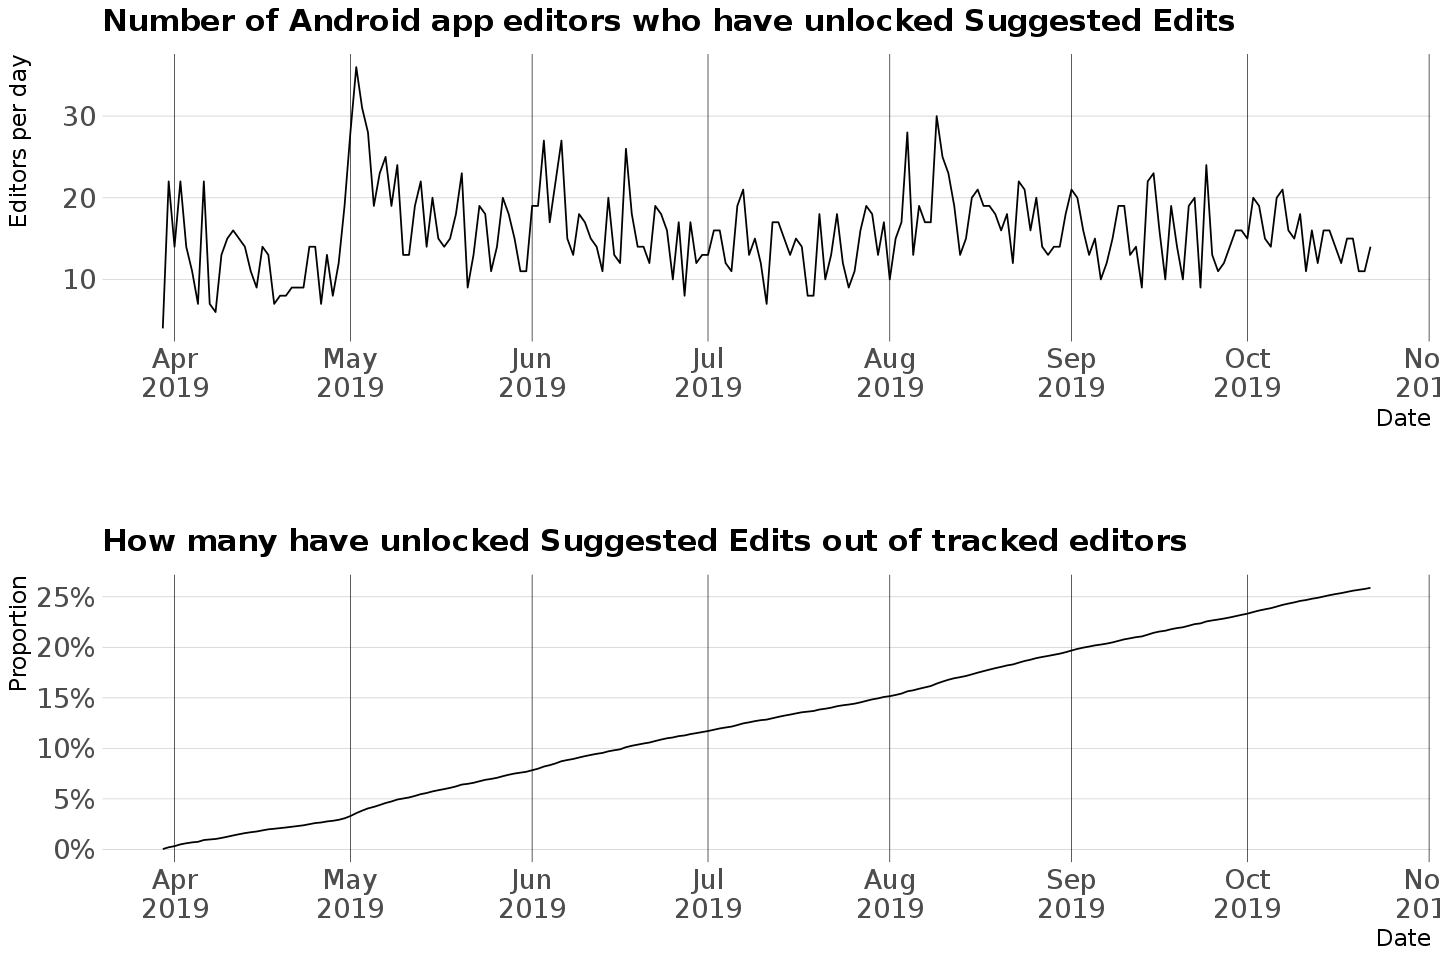

In [9]:
options(repr.plot.width = 12, repr.plot.height = 8)
p1 <- ggplot(backend_stats, aes(x = date, y = unlocked)) +
    geom_line() +
    scale_y_continuous(labels = compress, minor_breaks = NULL) +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(panel.grid.major.x = element_line(color = "gray10")) +
    labs(x = "Date", y = "Editors per day", title = "Number of Android app editors who have unlocked Suggested Edits")
p2 <- ggplot(backend_stats, aes(x = date, y = prop)) +
    geom_line() +
    scale_y_continuous(labels = scales::percent_format(1), minor_breaks = NULL, breaks = seq(0, 1, 0.05)) +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(panel.grid.major.x = element_line(color = "gray10")) +
    labs(x = "Date", y = "Proportion", title = "How many have unlocked Suggested Edits out of tracked editors")
p1 + p2 + plot_layout(ncol = 1)

**Notes**: The backend service starts tracking title description & image caption edits once the user makes one, and the database of counts of users' in-app edits was not populated retroactively prior to launch.

## Edit stats

### Edits and editors

In [10]:
editor_query <- "
SELECT
  actor_name AS user_name,
  SUBSTR(rev_timestamp, 1, 8) AS `date`,
  SUM(IF(INSTR(rev_comment, '#suggestededit') > 0 OR INSTR(comment_text, '#suggestededit') > 0, 1, 0)) AS suggested_edits,
  COUNT(1) AS total_edits
FROM revision
LEFT JOIN revision_comment_temp rct ON revision.rev_id = rct.revcomment_rev
LEFT JOIN `comment` ON rct.revcomment_comment_id = `comment`.comment_id
LEFT JOIN change_tag ON revision.rev_id = change_tag.ct_rev_id
LEFT JOIN revision_actor_temp rat ON revision.rev_id = rat.revactor_rev
LEFT JOIN actor ON rat.revactor_actor = actor.actor_id
${extra_join}
WHERE rev_timestamp >= '${rev_timestamp}'
  AND actor_user IS NOT NULL
  AND rat.revactor_actor > 0 -- remove anon edits (T188327 & T215466)
  AND ct_tag_id = ${change_tag} -- android app edit
  ${extra_condition}
GROUP BY user_name, `date`;
"

query_parameters <- list(
    wiki_db = c("title description" = "wikidatawiki", "image caption" = "commonswiki"),
    rev_timestamp = c("20190401", "20190601"),
    change_tag = c(14, 22),
    extra_join = c("", "LEFT JOIN page ON revision.rev_page = page.page_id"),
    extra_condition = c("", "AND INSTR(comment_text, '* wbsetlabel-') > 0 AND page_namespace = 6")
)

fetch_editor_stats <- function(wiki_db, rev_timestamp, change_tag, extra_join, extra_condition) {
    editor_query <- glue(editor_query, .open = "${")
    editor_stats <- suppress_messages_warnings(wmf::mysql_read(editor_query, wiki_db))
    return(editor_stats)
}

editor_data <- purrr::pmap_dfr(query_parameters, fetch_editor_stats, .id = "edit_type") %>%
  mutate(date = as.Date(date, "%Y%m%d")) %>%
  keep_where(date < today)

Title descriptions and image captions made through the Suggested Edits feature have the comment "#suggestededit", which enables us to differentiate between those edits and regular edits (which can be made when reading an article).

The following is a breakdown of:

- how many title description & image caption edits have been made with the feature (and without it)
- how many editors have made Wikidata description edits & Commons image captions through the Suggested Edits feature each day

This includes the Mobile Apps and Reading Infrastucture teams who have made contributions as part of the development and QA, prior to the public release of the beta and production versions of the app.

In [11]:
made_with <- editor_data %>%
    keep_where(date < today & date >= "2019-04-04") %>%
    mutate(non_suggested_edits = total_edits - suggested_edits) %>%
    group_by(edit_type, date) %>%
    summarize(
         `outside Suggested Edits` = sum(non_suggested_edits),
         `inside Suggested Edits` = sum(suggested_edits)
    ) %>%
    mutate(day = 1:n()) %>%
    ungroup %>%
    mutate(edit_type = factor(edit_type, c("title description", "image caption"), c("Title descriptions", "Image captions")))
contributor_counts <- editor_data %>%
    keep_where(date < today & date >= "2019-04-04") %>%
    keep_where(suggested_edits > 0) %>%
    arrange(user_name, date) %>%
    group_by(user_name) %>%
    mutate(returning = date > min(date)) %>%
    ungroup %>%
    dplyr::count(date, returning) %>%
    mutate(returning = factor(returning, c(FALSE, TRUE), c("First-time", "Returning")))
edit_date_range <- list(
    title_description = c(as.Date("2019-04-04"), yesterday),
    image_caption = c(as.Date("2019-06-06"), yesterday)
)

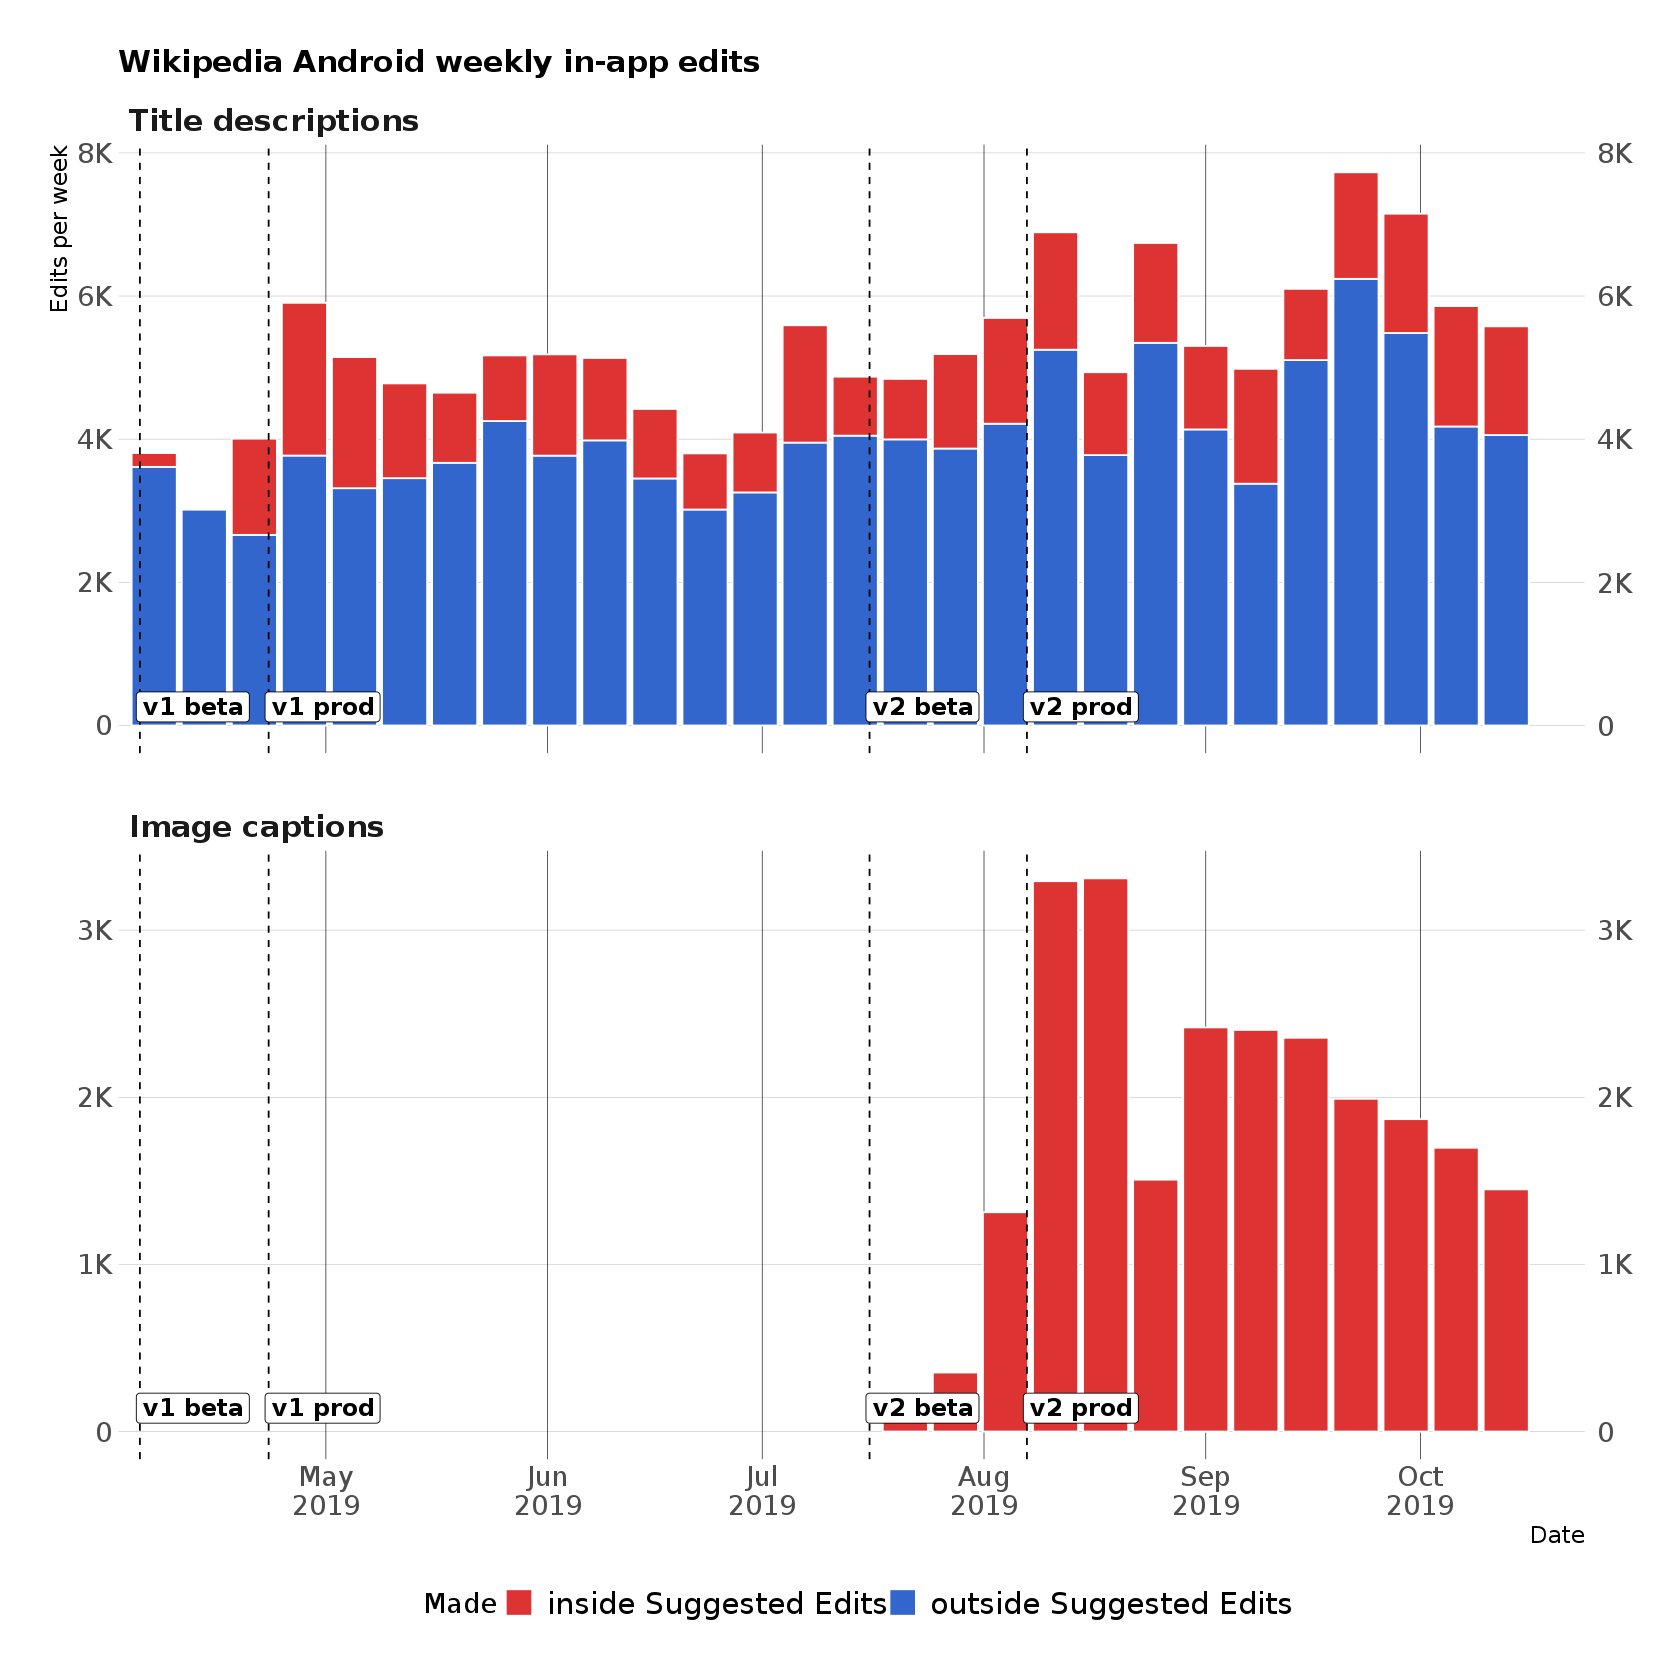

In [12]:
options(repr.plot.width = 14, repr.plot.height = 14)
made_with %>%
    gather(made, edits, -c(date, day, edit_type)) %>%
    # aggregate by week:
    mutate(date = lubridate::floor_date(date, "week")) %>%
    group_by(date, made, edit_type) %>%
    summarize(edits = sum(edits), days = dplyr::n()) %>%
    ungroup %>%
    keep_where(days == 7) %>%
    ggplot() +
    geom_col(aes(x = date,  y = edits, fill = made), position = "stack", color = "white") +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "black") +
    geom_label(aes(x = date - 0.5, y = 50, label = release), data = feature_release_dates, size = 5,
              vjust = "bottom", hjust = "left", fontface = "bold") +
    scale_fill_manual(
        values = c("inside Suggested Edits" = "#dd3333", "outside Suggested Edits" = "#3366cc")
    ) +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y", expand = c(0, 2)) +
    scale_y_continuous(minor_breaks = NULL, labels = compress,
                       sec.axis = sec_axis(~ ., labels = derive(), breaks = derive())) +
    coord_cartesian(xlim = edit_date_range$title_description) +
    facet_wrap(~ edit_type, ncol = 1, scales = "free_y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), legend.text = element_text(size = 18),
          panel.grid.major.x = element_line(color = "gray10")) +
    labs(x = "Date", y = "Edits per week", fill = "Made", title = "Wikipedia Android weekly in-app edits")

**How to read these charts**: on 8 April 2019, there were 3 total editors who collectively made 108 edits through the Editor Tasks (Suggested Edits) workflow. Of those 3 editors, 1 was somebody who made a contribution through Suggested Edits for the first time and 2 others were editors who have Suggested Edits-made contributions to their name already.

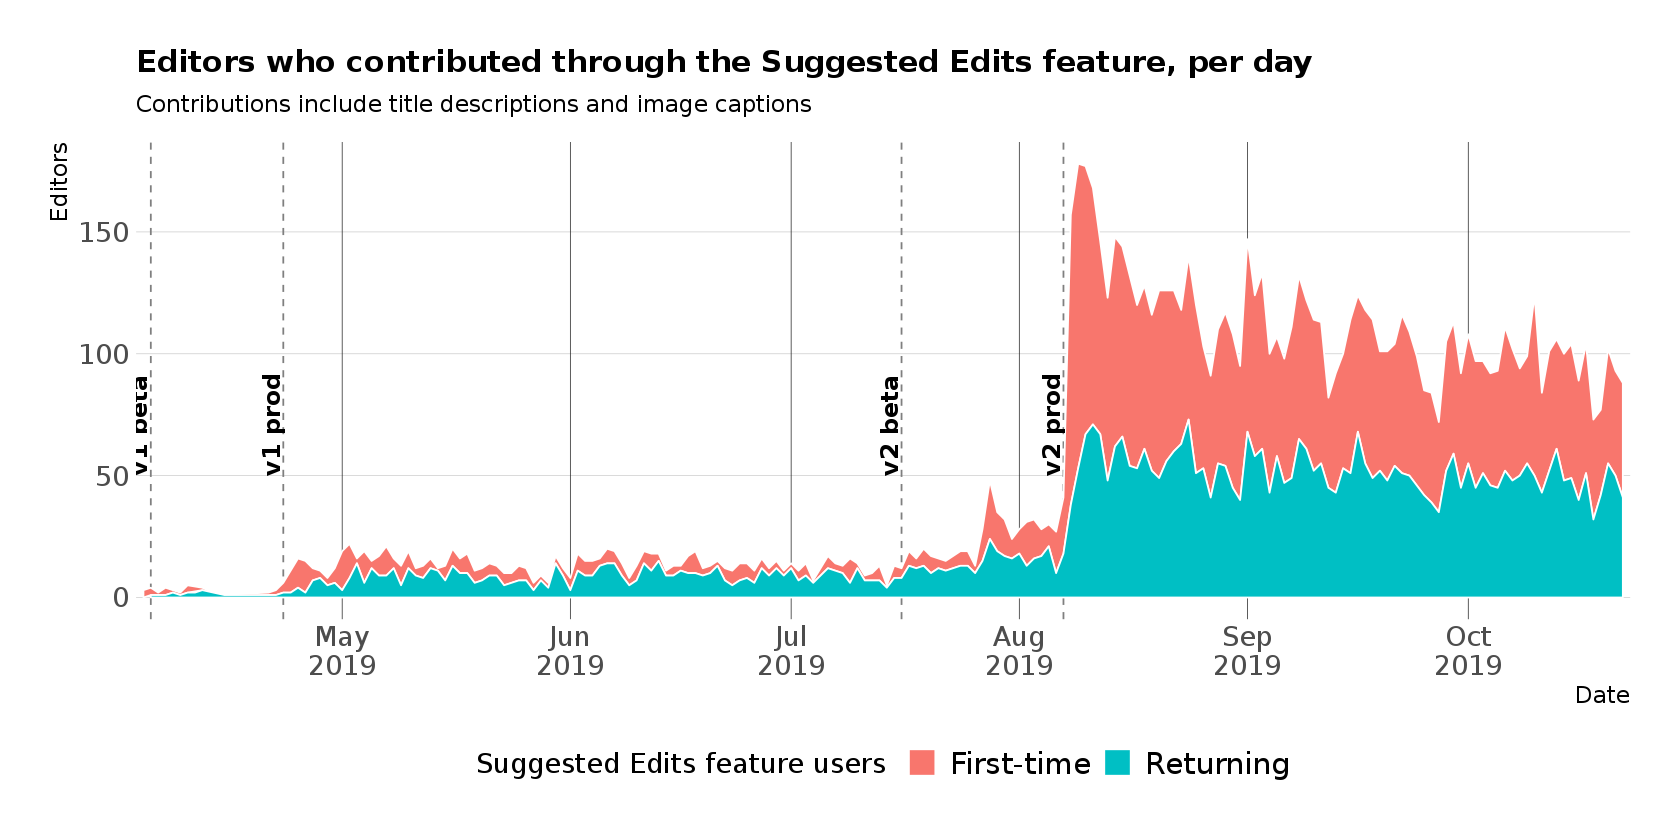

In [13]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(contributor_counts) +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_area(aes(x = date, y = n, fill = returning), position = "stack", color = "white") +
    geom_text(aes(x = date - 0.5, y = 50, label = release), data = feature_release_dates, size = 5, angle = 90,
              vjust = "bottom", hjust = "left", fontface = "bold") +
    scale_y_continuous(labels = compress, minor_breaks = NULL) +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y", expand = c(0, 1)) +
    coord_cartesian(xlim = edit_date_range$title_description) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", legend.text = element_text(size = 18),
          panel.grid.major.x = element_line(color = "gray10")) +
    labs(x = "Date", y = "Editors", fill = "Suggested Edits feature users   ",
         title = "Editors who contributed through the Suggested Edits feature, per day",
         subtitles = "Contributions include title descriptions and image captions")

### Title descriptions vs image captions

Now that users can make two different types of edits (title descriptions and image captions), we can start to compare to the proportion of edits of one type versus the other. For our purposes, we do not differentiate between adding and translating.

In [14]:
contributions_proportions <- made_with %>%
    gather(made, edits, -c(date, day, edit_type)) %>%
    mutate(contribution = paste(edit_type, made)) %>%
    select(date, contribution, edits) %>%
    group_by(date) %>%
    mutate(prop = edits / sum(edits)) %>%
    ungroup %>%
    group_by(contribution) %>%
    arrange(date) %>%
    mutate(day = 1:n()) %>%
    ungroup

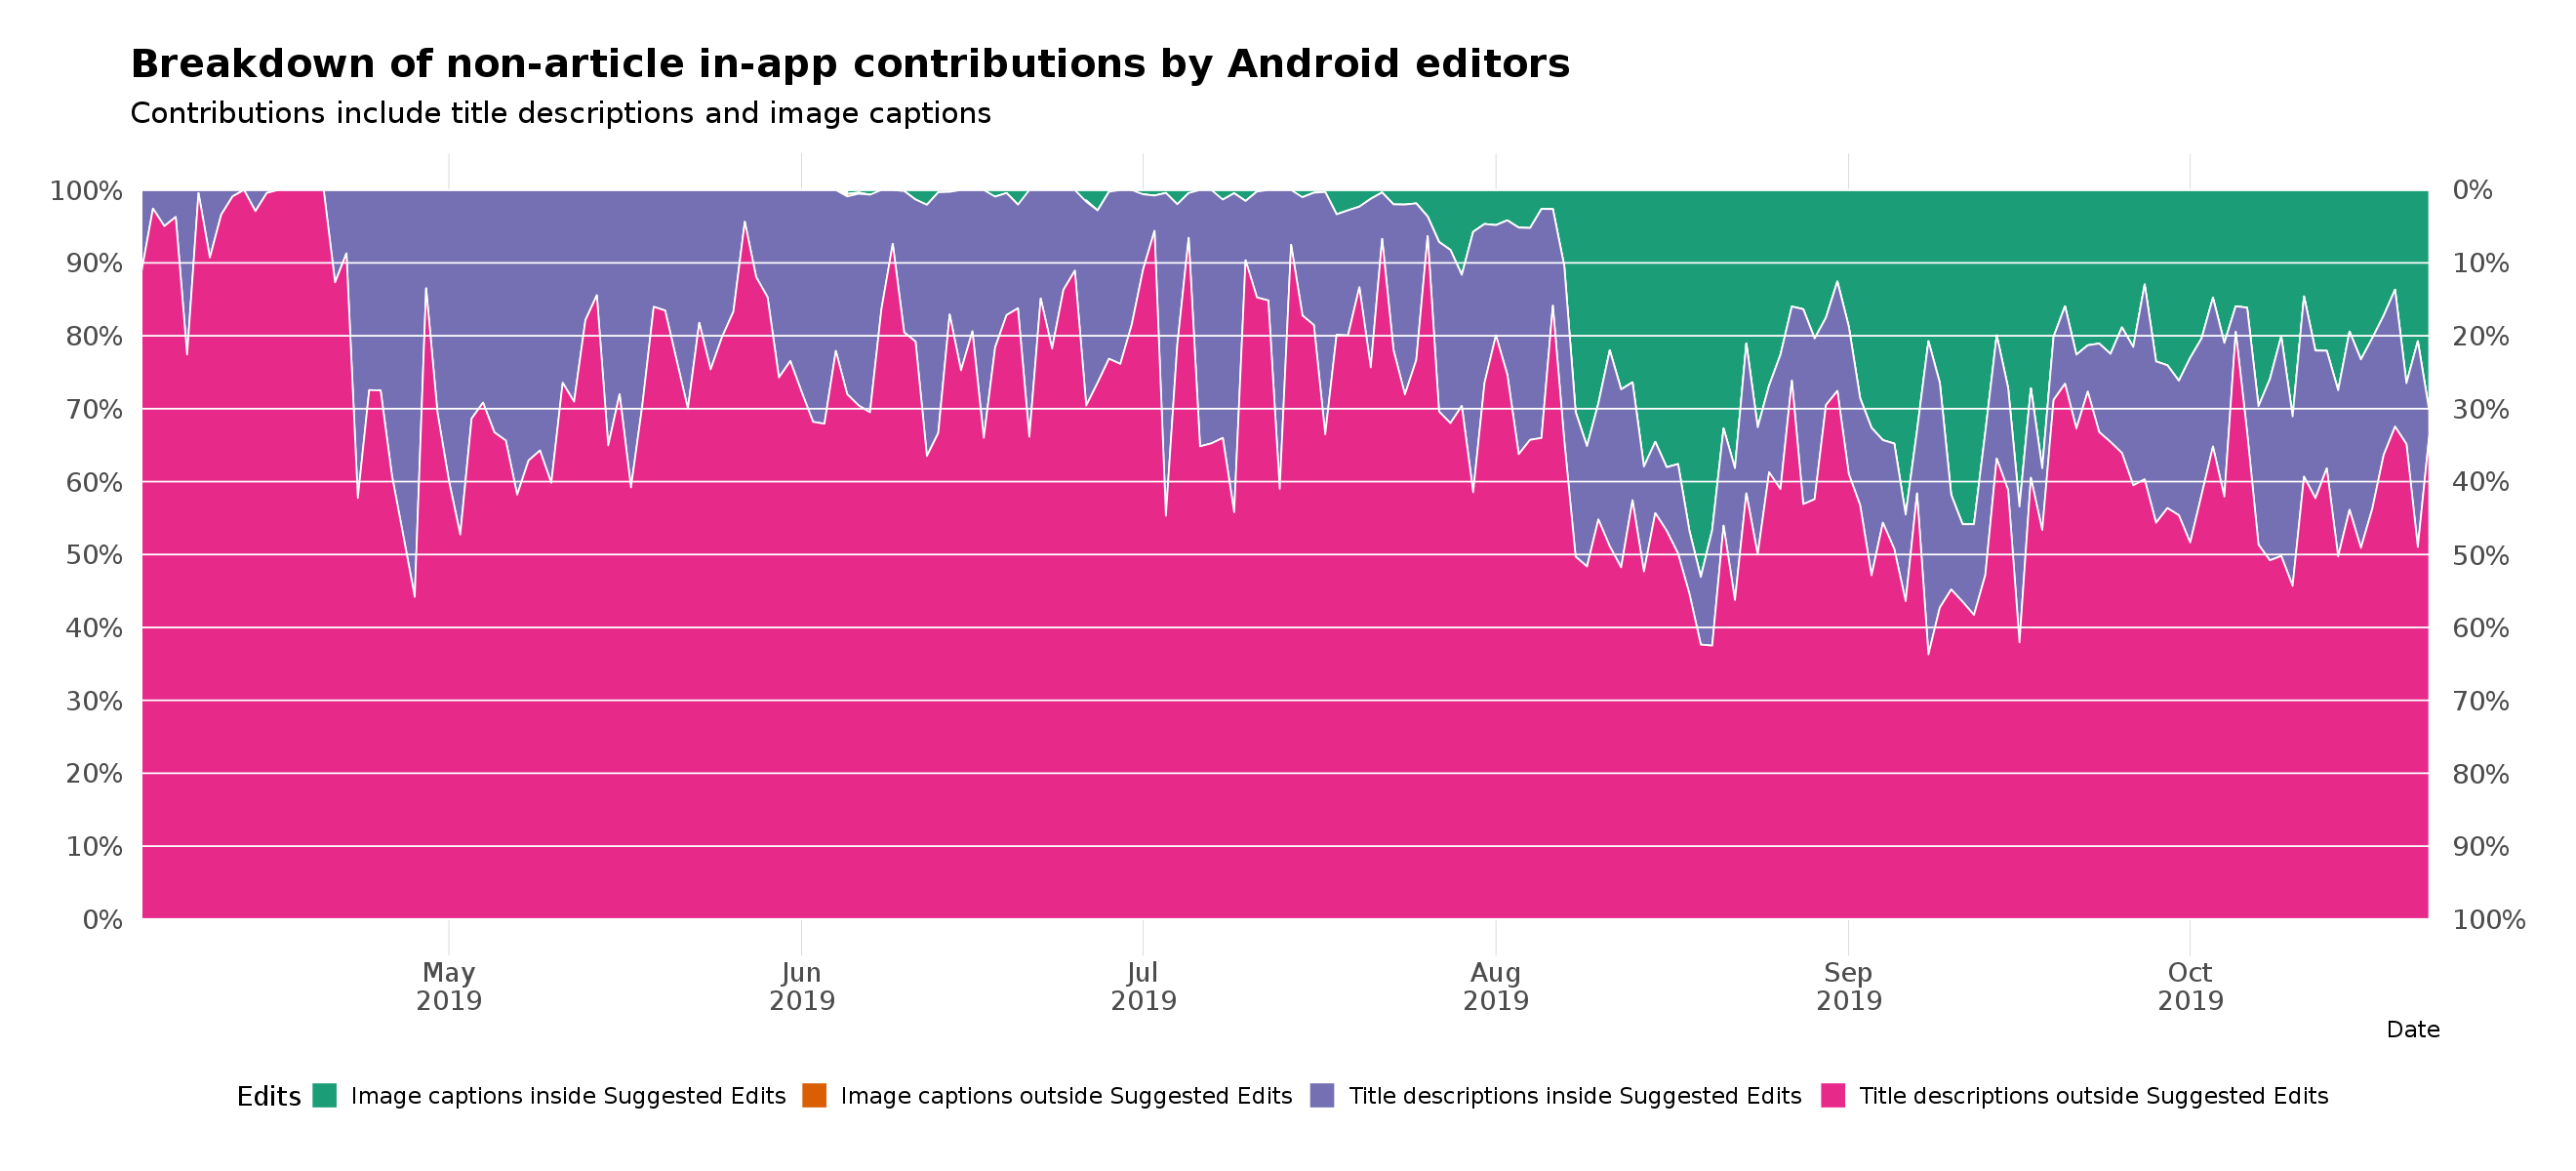

In [15]:
options(repr.plot.width = 22, repr.plot.height = 10)
ggplot(contributions_proportions) +
    geom_area(aes(x = date, fill = contribution, y = edits), position = "fill", color = "white") +
    geom_hline(yintercept = seq(0, 1, 0.1), color = "white") +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y", expand = c(0, 1)) +
    scale_y_continuous(
        minor_breaks = NULL, breaks = seq(0, 1, 0.1), labels = scales::percent_format(1),
        sec.axis = sec_axis(~ 1 - ., labels = derive(), breaks = derive())
    ) +
    scale_fill_brewer(palette = "Dark2") +
    coord_cartesian(xlim = edit_date_range$title_description) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", plot_title_size = 24,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 18) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), legend.text = element_text(size = 14)) +
    labs(x = "Date", y = NULL, fill = "Edits",
         title = "Breakdown of non-article in-app contributions by Android editors",
         subtitles = "Contributions include title descriptions and image captions")

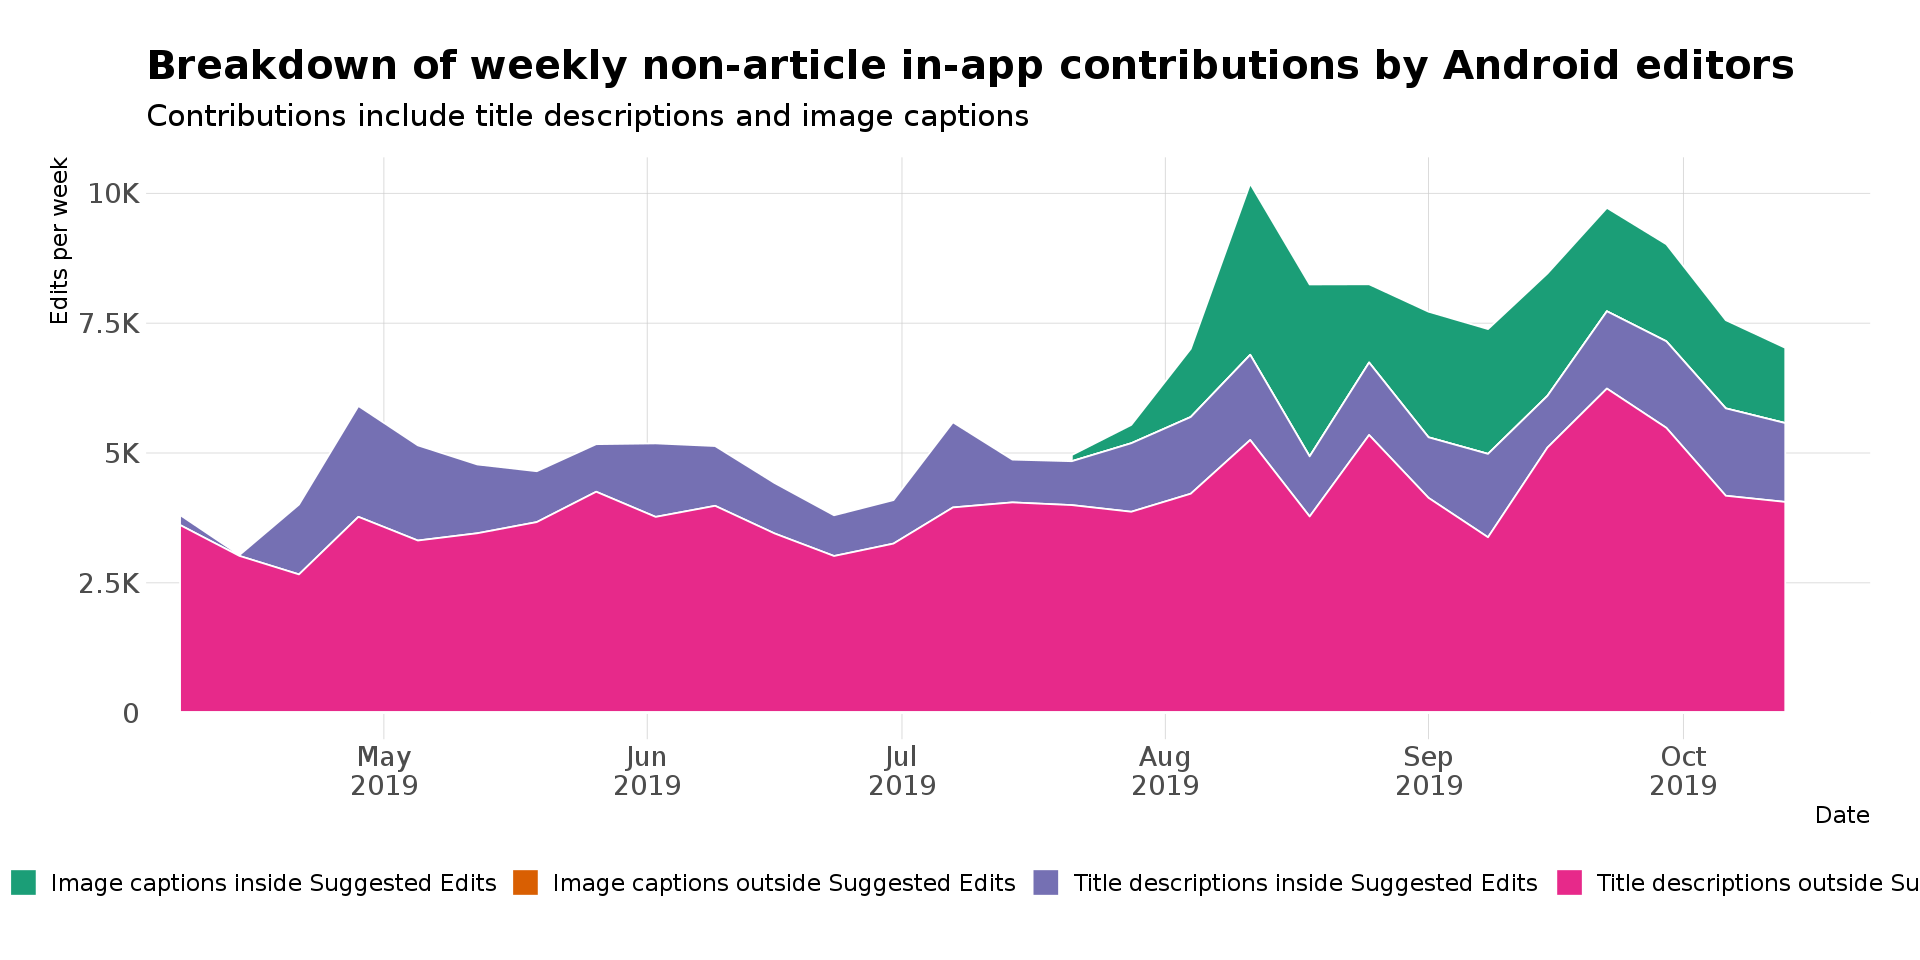

In [16]:
options(repr.plot.width = 16, repr.plot.height = 8)
contributions_proportions %>%
    mutate(date = lubridate::floor_date(date, "week")) %>%
    group_by(contribution, date) %>%
    summarize(edits = sum(edits), days = dplyr::n()) %>%
    ungroup %>%
    keep_where(days == 7) %>%
    ggplot() +
    geom_area(aes(x = date, fill = contribution, y = edits), position = "stack", color = "white") +
    geom_hline(yintercept = seq(0, 1, 0.1), color = "white") +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y", expand = c(0, 1)) +
    scale_y_continuous(labels = polloi::compress) +
    scale_fill_brewer(palette = "Dark2") +
    coord_cartesian(xlim = edit_date_range$title_description) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", plot_title_size = 24,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 18) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), legend.text = element_text(size = 14)) +
    labs(x = "Date", y = "Edits per week", fill = "Edits",
         title = "Breakdown of weekly non-article in-app contributions by Android editors",
         subtitles = "Contributions include title descriptions and image captions")

First is the comparison of each type of edit and how many were made through Suggested Edits versus in article view:

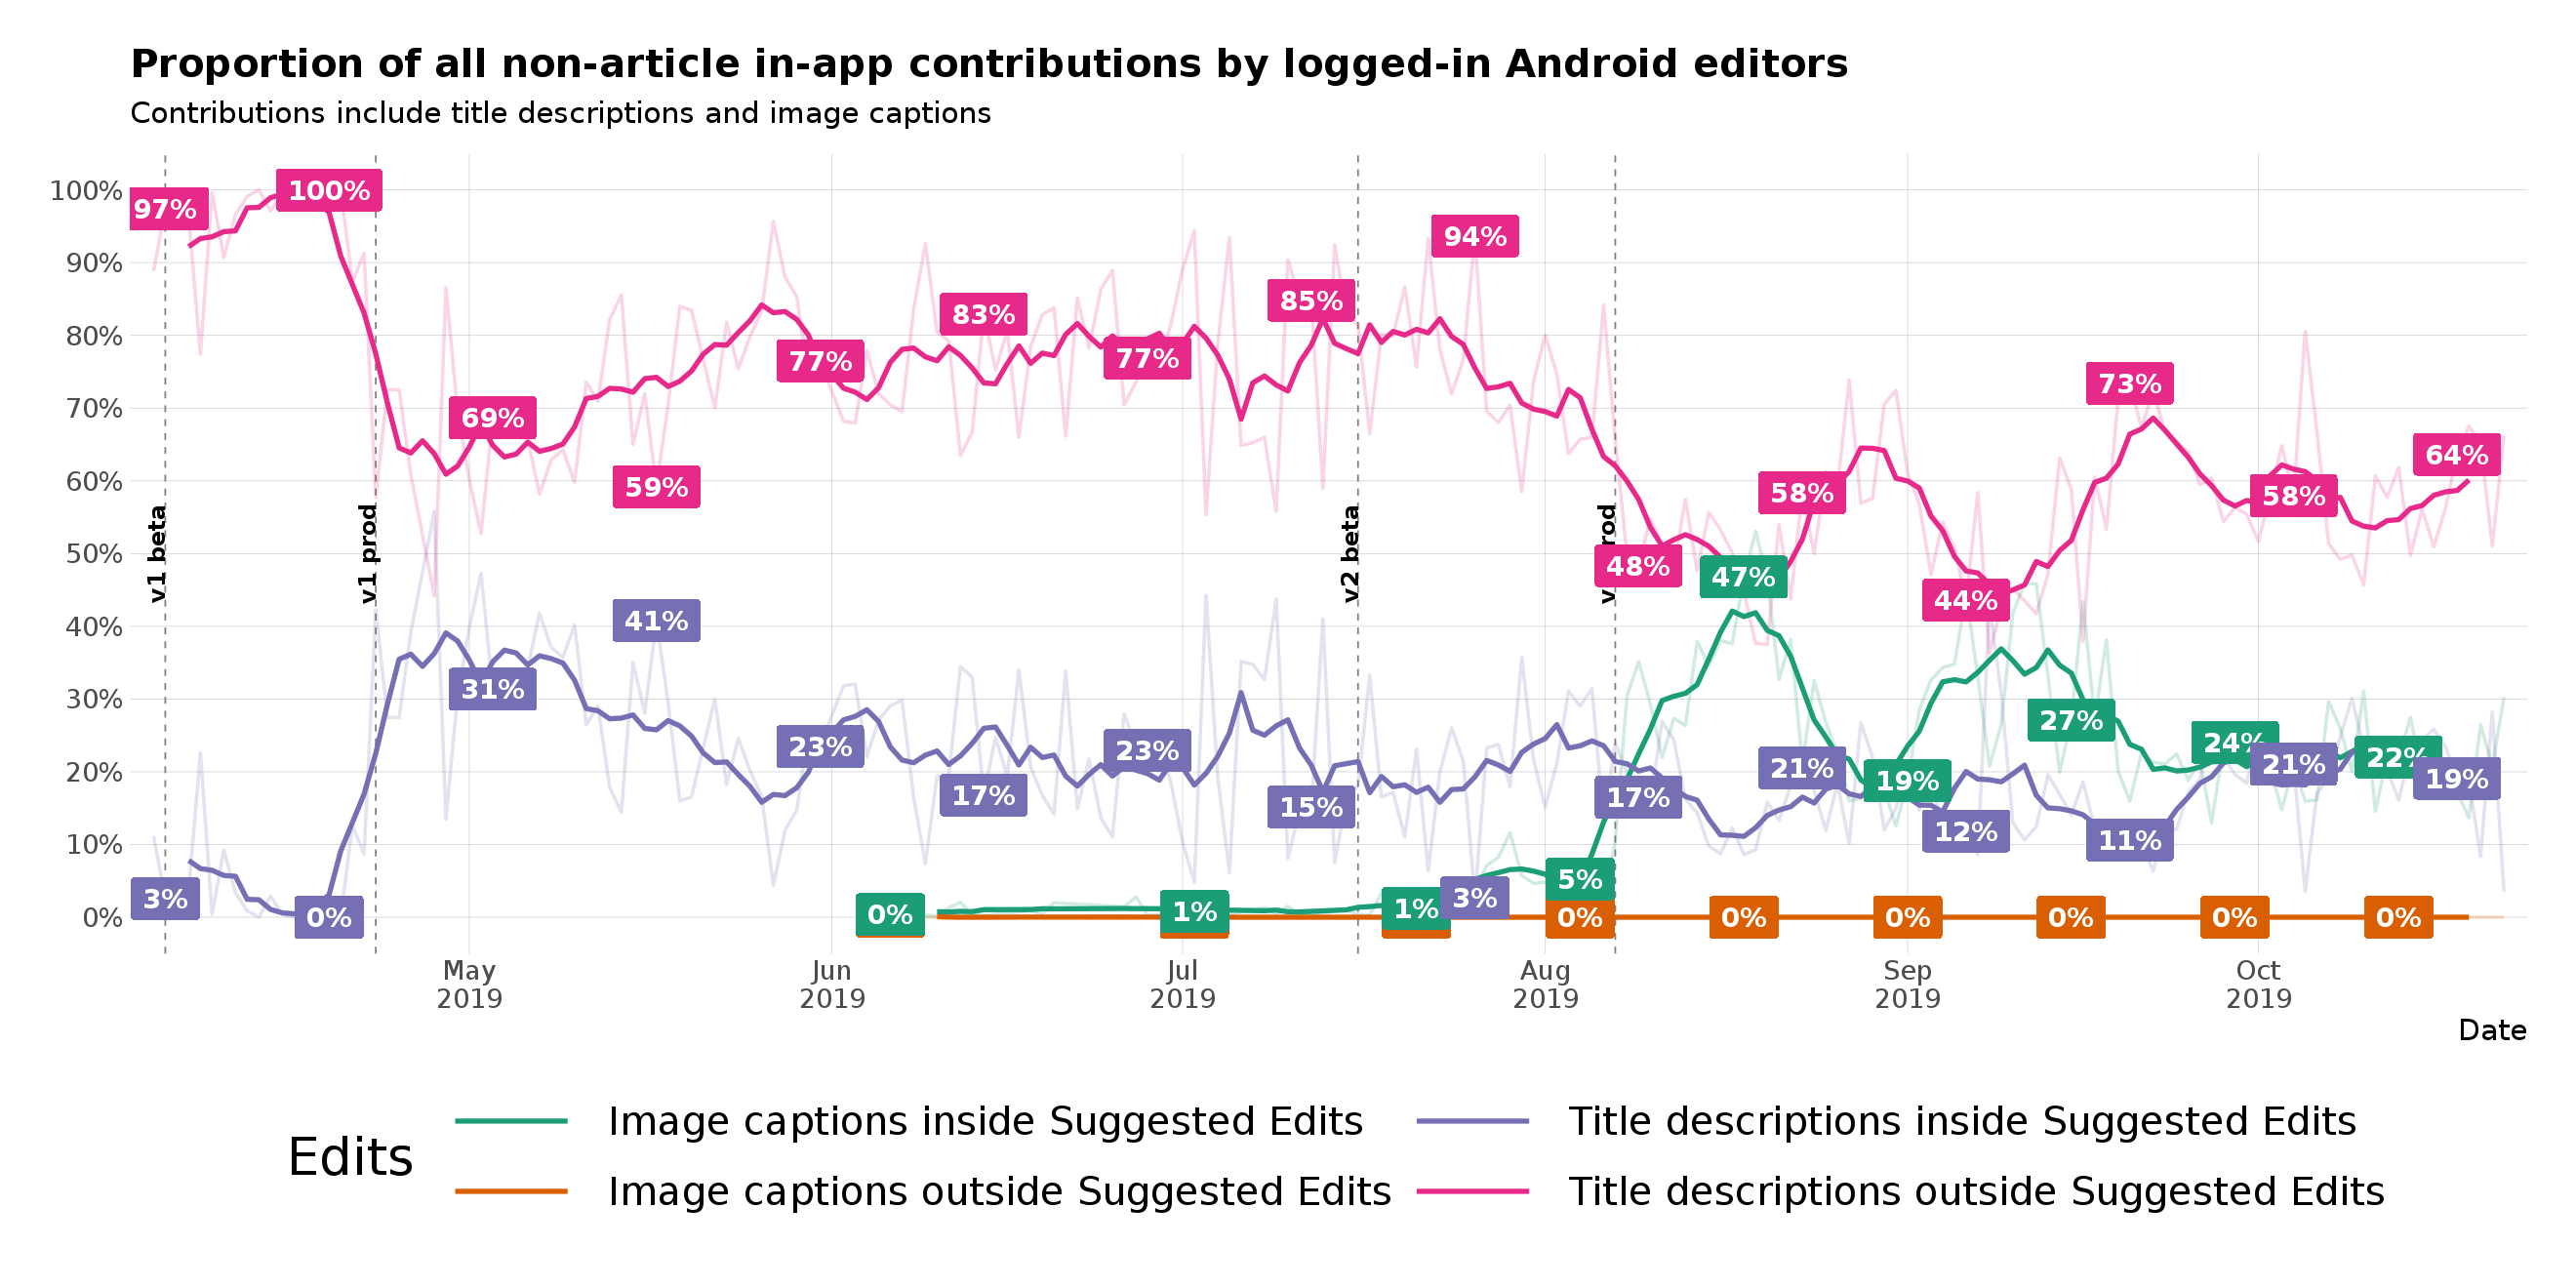

In [17]:
options(repr.plot.width = 22, repr.plot.height = 11)
contributions_proportions %>%
    group_by(contribution) %>%
    arrange(date) %>%
    mutate(roll_prop = c(rep(NA, 3), RcppRoll::roll_mean(prop, 7), c(rep(NA, 3)))) %>%
    ungroup %>%
    ggplot(aes(x = date)) +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_text(aes(x = date, y = 0.5, label = release), data = feature_release_dates, size = 5, angle = 90,
              vjust = "bottom", hjust = "middle", fontface = "bold") +
    geom_line(aes(y = prop, color = contribution), size = 1, alpha = 0.2) +
    geom_line(aes(y = roll_prop, color = contribution), size = 1.5) +
    geom_label(
        aes(y = prop, label = sprintf("%.0f%%", 100 * prop), fill = contribution),
        data = keep_where(contributions_proportions, day %% 14 == 2),
        size = 6, fontface = "bold", color = "white", label.padding = unit(0.5, "lines"), label.size = 0,
        show.legend = FALSE
    ) +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y", expand = c(0, 2)) +
    scale_y_continuous(
        labels = scales::percent_format(1), limits = c(0, 1),
        breaks = seq(0, 1, 0.1), minor_breaks = NULL
    ) +
    scale_color_brewer(palette = "Dark2", guide = guide_legend(ncol = 2)) +
    scale_fill_brewer(palette = "Dark2") +
    coord_cartesian(xlim = edit_date_range$title_description) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", plot_title_size = 24,
                            caption_size = 12, axis_title_size = 18, subtitle_size = 18) +
    theme(legend.position = "bottom", legend.text = element_text(size = 24), legend.title = element_text(size = 32),
          legend.key.width = unit(6, "lines"), legend.key.height = unit(3, "lines")) +
    labs(x = "Date", y = NULL, color = "Edits",
         title = "Proportion of all non-article in-app contributions by logged-in Android editors",
         subtitles = "Contributions include title descriptions and image captions")

Second is the comparison of how many edits of each type were made specifically through Suggested Edits:

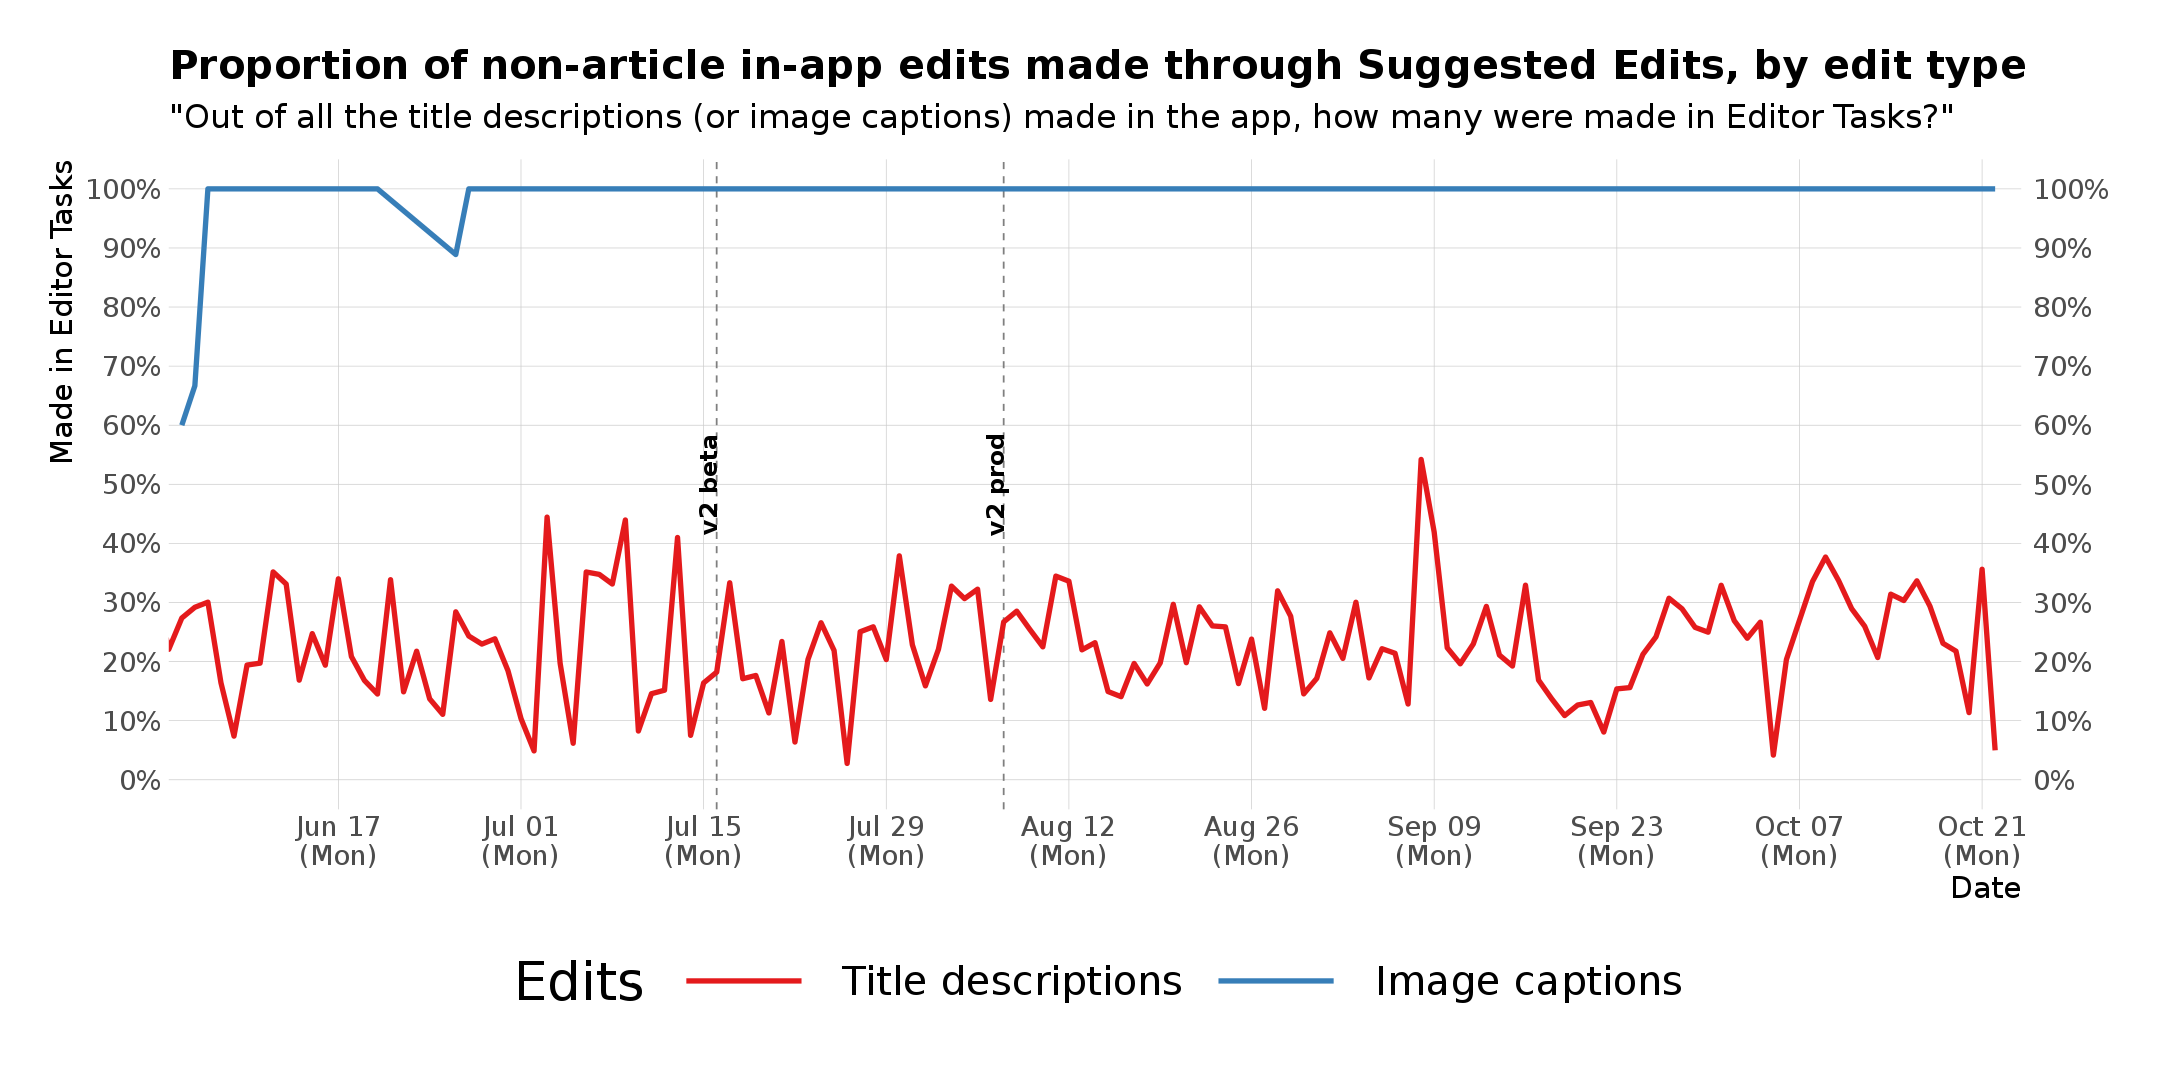

In [18]:
edit_type_proportions <- made_with %>%
    group_by(date, edit_type) %>%
    summarize(prop = `inside Suggested Edits` / (`inside Suggested Edits` + `outside Suggested Edits`)) %>%
    ungroup %>%
    group_by(edit_type) %>%
    arrange(date) %>%
    mutate(day = 1:n()) %>%
    ungroup %>%
    mutate(edit_type = factor(edit_type, c("Title descriptions", "Image captions")))

options(repr.plot.width = 18, repr.plot.height = 9)
ggplot(edit_type_proportions, aes(x = date, y = prop)) +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_text(aes(x = date, y = 0.5, label = release), data = feature_release_dates, size = 5, angle = 90,
              vjust = "bottom", hjust = "middle", fontface = "bold") +
    geom_line(aes(color = edit_type), size = 1.5) +
    scale_x_date(date_breaks = "2 weeks", minor_breaks = NULL, date_labels = "%b %d\n(%a)", expand = c(0, 2)) +
    scale_y_continuous(
        labels = scales::percent_format(1), limits = c(0, 1),
        breaks = seq(0, 1, 0.1), minor_breaks = NULL,
        sec.axis = sec_axis(~ ., labels = derive(), breaks = derive())
    ) +
    scale_color_brewer(palette = "Set1", guide = guide_legend(ncol = 2)) +
    coord_cartesian(xlim = edit_date_range$image_caption) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", plot_title_size = 24,
                            caption_size = 12, axis_title_size = 18, subtitle_size = 20) +
    theme(legend.position = "bottom", legend.text = element_text(size = 24), legend.title = element_text(size = 32),
          legend.key.width = unit(6, "lines"), legend.key.height = unit(3, "lines")) +
    labs(x = "Date", y = "Made in Editor Tasks", color = "Edits",
         title = "Proportion of non-article in-app edits made through Suggested Edits, by edit type",
         subtitle = "\"Out of all the title descriptions (or image captions) made in the app, how many were made in Editor Tasks?\"")

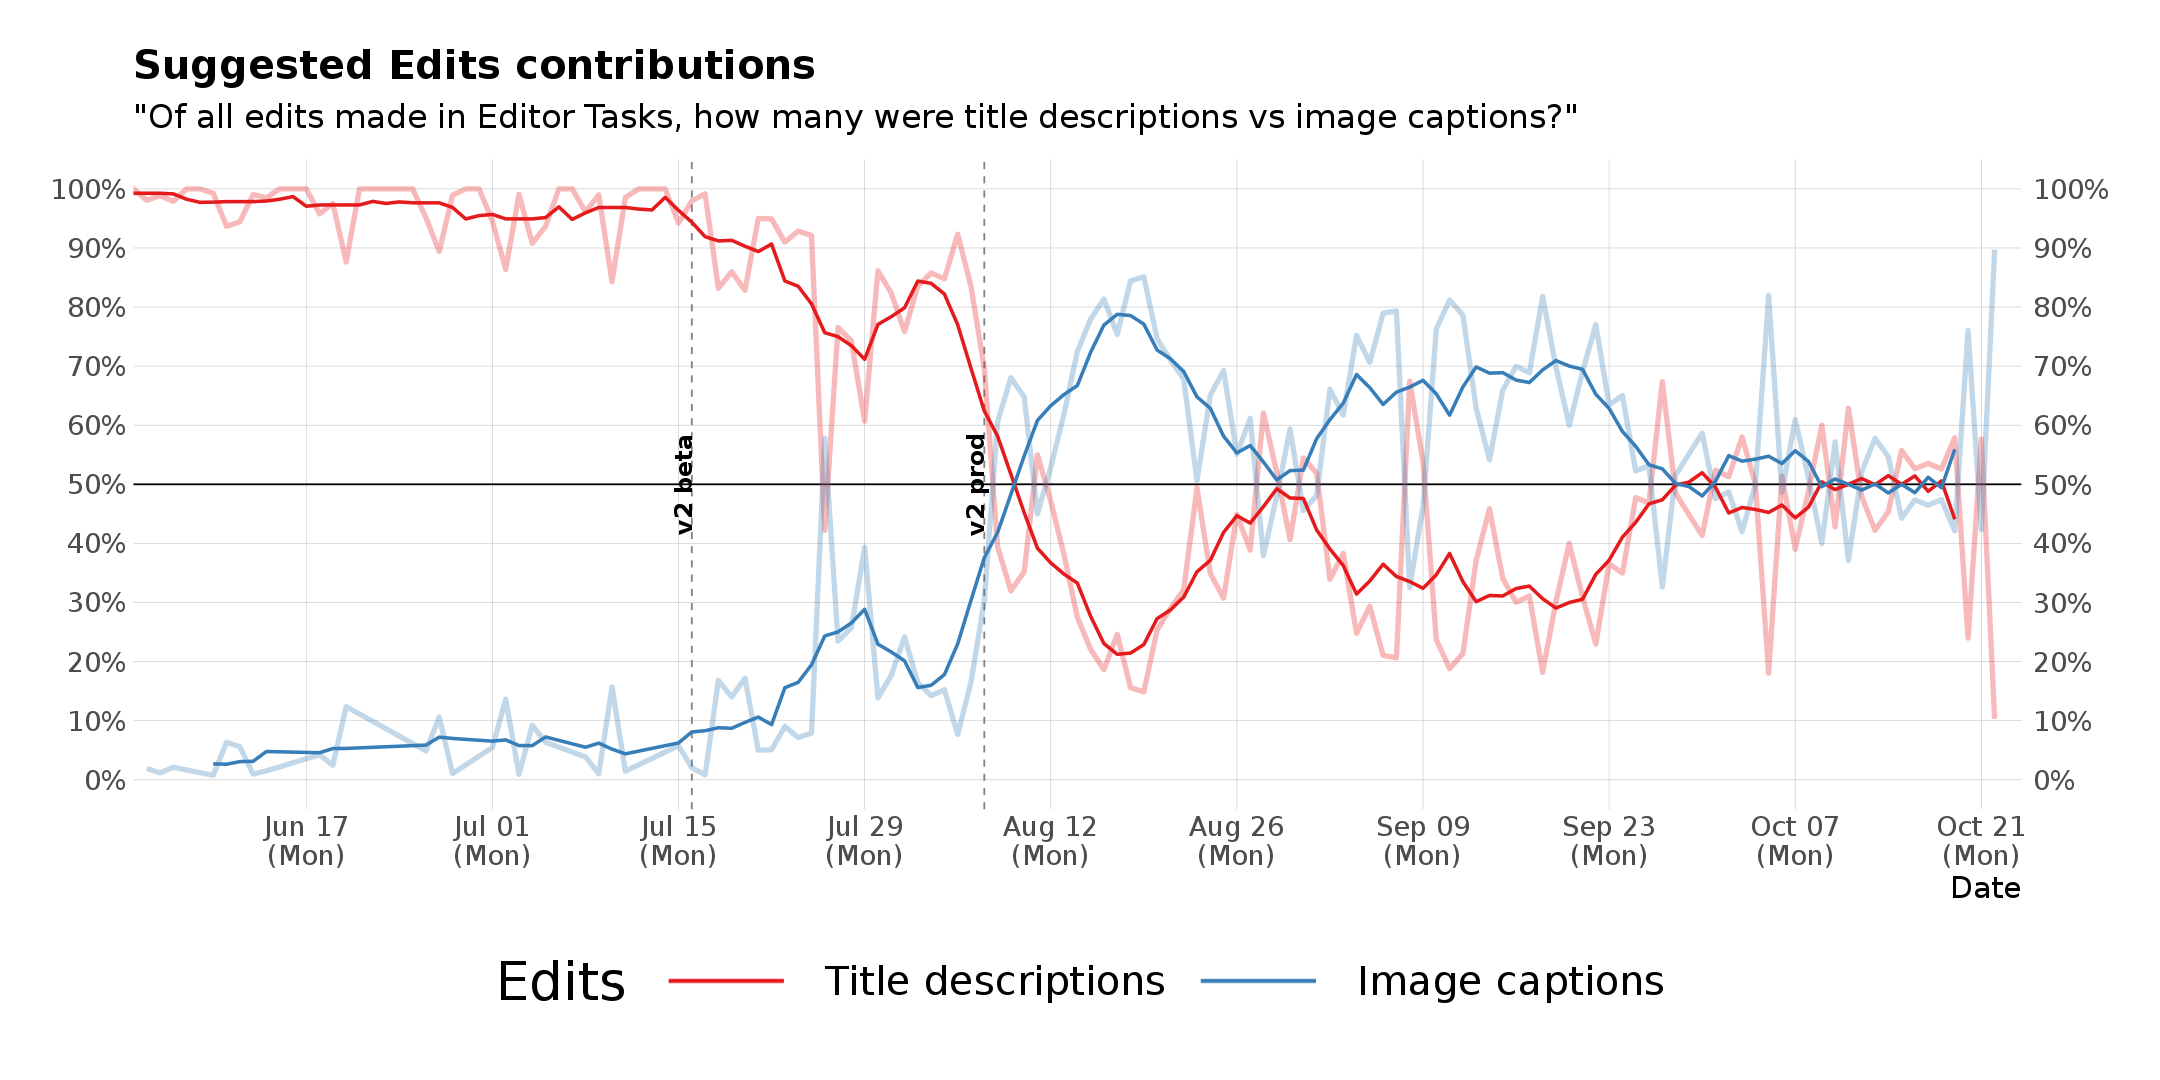

In [19]:
options(repr.plot.width = 18, repr.plot.height = 9)

suggested_edits_proportions <- made_with %>%
    select(edit_type, date, edits = `inside Suggested Edits`, day) %>%
    group_by(date) %>%
    mutate(prop = edits / sum(edits), prop = nan2na(prop)) %>%
    ungroup %>%
    group_by(edit_type) %>%
    arrange(date) %>%
    mutate(day = 1:n(), roll_prop = c(rep(NA, 3), RcppRoll::roll_mean(prop, 7), c(rep(NA, 3)))) %>%
    ungroup

ggplot(suggested_edits_proportions, aes(x = date, y = prop)) +
    geom_hline(yintercept = 0.5) +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_text(aes(x = date, y = 0.5, label = release), data = feature_release_dates, size = 5, angle = 90,
              vjust = "bottom", hjust = "middle", fontface = "bold") +
    geom_line(aes(color = edit_type), size = 1.5, alpha = 0.3) +
    geom_line(aes(color = edit_type, y = roll_prop), size = 1) +
    scale_x_date(date_breaks = "2 weeks", minor_breaks = NULL, date_labels = "%b %d\n(%a)", expand = c(0, 2)) +
    scale_y_continuous(
        labels = scales::percent_format(1), limits = c(0, 1),
        breaks = seq(0, 1, 0.1), minor_breaks = NULL,
        sec.axis = sec_axis(~ ., labels = derive(), breaks = derive())
    ) +
    scale_color_brewer(palette = "Set1", guide = guide_legend(ncol = 2)) +
    coord_cartesian(xlim = edit_date_range$image_caption) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", plot_title_size = 24,
                            caption_size = 12, axis_title_size = 18, subtitle_size = 20) +
    theme(legend.position = "bottom", legend.text = element_text(size = 24), legend.title = element_text(size = 32),
          legend.key.width = unit(6, "lines"), legend.key.height = unit(3, "lines")) +
    labs(x = "Date", y = NULL, color = "Edits",
         title = "Suggested Edits contributions",
         subtitle = "\"Of all edits made in Editor Tasks, how many were title descriptions vs image captions?\"")

### Revert rate

Using the [`mwreverts` library](https://pythonhosted.org/mwreverts/) we can query the MediaWiki API to check on the revert status of revisions. For our purposes we specify a window of 48 hours from the time the edit was made. That is, if an edit is reverted at some point after 48 hours but not before, we do not count that edit as reverted.

In [20]:
revert_status_columns <- c("rev_date", "rev_ts", "rev_id", "page_id", "user_name", "made", "reverted", "reverting_rev")
revert_status_data <- c("Image captions" = "image-captions", "Title descriptions" = "title-descriptions") %>%
    purrr::map_dfr(
        ~ readr::read_csv(glue("revert_status_data_{.x}.csv.gz"), col_types = "DTiiccli",
                          col_names = revert_status_columns, progress = FALSE, skip = 1),
        .id = "edit_type") %>%
    mutate(
        made = factor(made, c("suggested", "regular"), c("inside Suggested Edits", "outside Suggested Edits")),
        edit_type = factor(edit_type, c("Title descriptions", "Image captions"))
    )

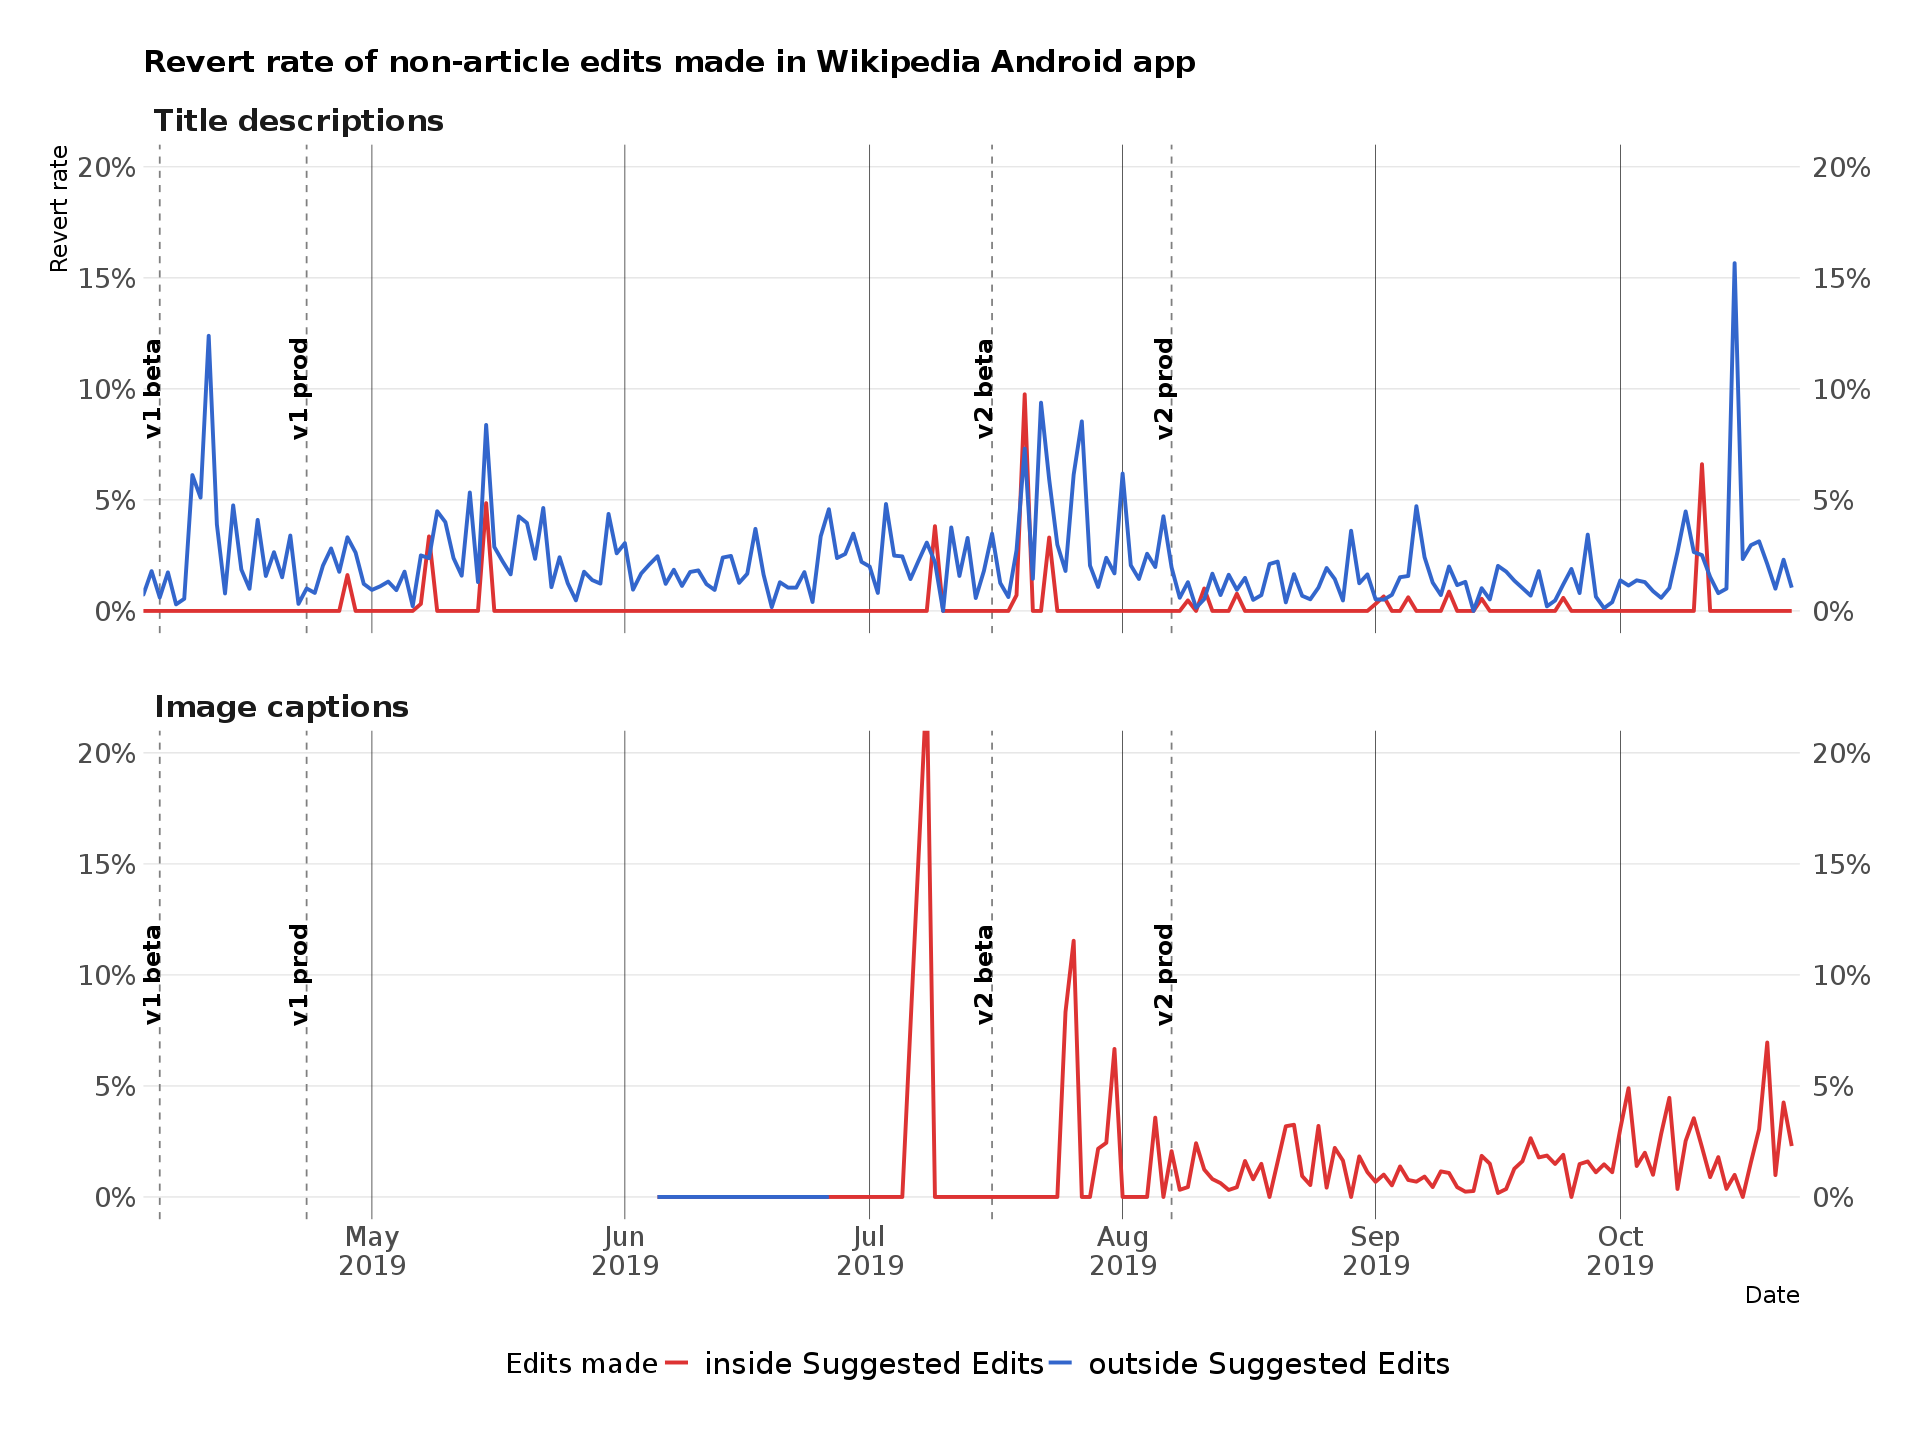

In [21]:
options(repr.plot.width = 16, repr.plot.height = 12)
revert_status_data %>%
    group_by(edit_type, rev_date, made) %>%
    summarize(revert_rate = mean(reverted)) %>%
    ungroup %>%
    ggplot() +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_text(aes(x = date, y = 0.1, label = release), data = feature_release_dates, size = 5, angle = 90,
              vjust = "bottom", hjust = "middle", fontface = "bold") +
    geom_line(aes(x = rev_date, y = revert_rate, color = made), size = 1.1) +
    scale_color_manual(values = c("inside Suggested Edits" = "#dd3333", "outside Suggested Edits" = "#3366cc")) +
    scale_y_continuous(labels = scales::percent_format(1), minor_breaks = NULL,
                       sec.axis = sec_axis(~ ., breaks = derive(), labels = derive())) +
    scale_x_date(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y", expand = c(0, 1)) +
    coord_cartesian(xlim = edit_date_range$title_description, ylim = c(0, 0.2)) +
    facet_wrap(~ edit_type, ncol = 1, scales = "free_y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), legend.text = element_text(size = 18),
          panel.grid.major.x = element_line(color = "gray10")) +
    labs(x = "Date", y = "Revert rate", color = "Edits made",
         title = "Revert rate of non-article edits made in Wikipedia Android app")

## Usage stats

In [22]:
ninety_days_ago <- format(today - 90, "%Y-%m-%d")
sanitized_el_query <- "
USE event_sanitized;
SELECT

  useragent.wmf_app_version AS app_version,
  event.app_install_id AS install_id,
  event.session_token AS session_id,
  
  -- Session summary:
  MIN(SUBSTR(event.client_dt, 1, 10)) AS session_start_date,
  COUNT(1) AS n_suggested_edits_sessions,
  SUM(event.time_spent) AS total_time_spent, -- in seconds
  SUM(event.help_opened) AS n_help, -- total times user looked at help
  SUM(event.scorecard_opened) AS n_scorecard, -- total times user looked at scorecard,

  -- Title descriptions:
  COALESCE(SUM(description_addition.impressions) + SUM(description_translation.impressions), 0L) AS n_td_suggestions, -- total impressions
  COALESCE(SUM(description_addition.unique_clicks) + SUM(description_translation.unique_clicks), 0L) AS n_td_accepts, -- total unique clickthroughs
  COALESCE(SUM(description_addition.total_clicks) + SUM(description_translation.total_clicks), 0L) AS n_td_clicks, -- total clickthroughs
  COALESCE(SUM(description_addition.cancels) + SUM(description_translation.cancels), 0L) AS n_td_cancels,
  COALESCE(SUM(description_addition.successes) + SUM(description_translation.successes), 0L) AS n_td_edits, -- total Wikidata descriptions edits
  
  -- Image captions:
  COALESCE(SUM(caption_addition.impressions) + SUM(caption_translation.impressions), 0L) AS n_ic_suggestions, -- total impressions
  COALESCE(SUM(caption_addition.unique_clicks) + SUM(caption_translation.unique_clicks), 0L) AS n_ic_accepts, -- total unique clickthroughs
  COALESCE(SUM(caption_addition.total_clicks) + SUM(caption_translation.total_clicks), 0L) AS n_ic_clicks, -- total clickthroughs
  COALESCE(SUM(caption_addition.cancels) + SUM(caption_translation.cancels), 0L) AS n_ic_cancels,
  COALESCE(SUM(caption_addition.successes) + SUM(caption_translation.successes), 0L) AS n_ic_edits -- total Commons caption edits

FROM MobileWikiAppSuggestedEdits

LATERAL VIEW
  JSON_TUPLE(event.edit_tasks, 'add-description', 'translate-description', 'add-caption', 'translate-caption') edit_tasks
  AS add_desc, translate_desc, add_cap, translate_cap

LATERAL VIEW
  JSON_TUPLE(edit_tasks.add_desc, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') description_addition
  AS impressions, total_clicks, unique_clicks, cancels, successes

LATERAL VIEW
  JSON_TUPLE(edit_tasks.translate_desc, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') description_translation
  AS impressions, total_clicks, unique_clicks, cancels, successes

LATERAL VIEW
  JSON_TUPLE(edit_tasks.add_cap, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') caption_addition
  AS impressions, total_clicks, unique_clicks, cancels, successes

LATERAL VIEW
  JSON_TUPLE(edit_tasks.translate_cap, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') caption_translation
  AS impressions, total_clicks, unique_clicks, cancels, successes

WHERE (
   (CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '2019-04-23')
   AND (CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) < '${ninety_days_ago}')
  )
  AND INSTR(useragent.wmf_app_version, '-r-') > 0
GROUP BY useragent.wmf_app_version, event.app_install_id, event.session_token;
"

In [23]:
old_events <- suppress_messages_warnings(wmf::query_hive(glue(sanitized_el_query, .open = "${"))) %>%
    dplyr::as_tibble() %>%
    mutate(
        session_start_date = as.Date(session_start_date),
        release = sub("^([0-9\\.]+)-([a-z]+)-[0-9]{4}-[0-9]{2}-[0-9]{2}$", "\\2", app_version),
        version = sub("^([0-9\\.]+)-([a-z]+)-[0-9]{4}-[0-9]{2}-[0-9]{2}$", "\\1", app_version),
        release = ifelse(release == "r", "production", release),
        dataset = "sanitized"
    ) %>%
    mutate(release = paste(polloi::capitalize_first_letter(release), "release"))

In [24]:
el_query <- "USE event;
SELECT

  useragent.wmf_app_version AS app_version,
  event.app_install_id AS install_id,
  event.session_token AS session_id,

  -- Session summary:
  MIN(SUBSTR(event.client_dt, 1, 10)) AS session_start_date,
  COUNT(1) AS n_suggested_edits_sessions,
  SUM(event.time_spent) AS total_time_spent, -- in seconds
  SUM(event.help_opened) AS n_help, -- total times user looked at help
  SUM(event.scorecard_opened) AS n_scorecard, -- total times user looked at scorecard,

  -- Title descriptions:
  COALESCE(SUM(description_addition.impressions) + SUM(description_translation.impressions), 0L) AS n_td_suggestions, -- total impressions
  COALESCE(SUM(description_addition.unique_clicks) + SUM(description_translation.unique_clicks), 0L) AS n_td_accepts, -- total unique clickthroughs
  COALESCE(SUM(description_addition.total_clicks) + SUM(description_translation.total_clicks), 0L) AS n_td_clicks, -- total clickthroughs
  COALESCE(SUM(description_addition.cancels) + SUM(description_translation.cancels), 0L) AS n_td_cancels,
  COALESCE(SUM(description_addition.successes) + SUM(description_translation.successes), 0L) AS n_td_edits, -- total Wikidata descriptions edits

  -- Image captions:
  COALESCE(SUM(caption_addition.impressions) + SUM(caption_translation.impressions), 0L) AS n_ic_suggestions, -- total impressions
  COALESCE(SUM(caption_addition.unique_clicks) + SUM(caption_translation.unique_clicks), 0L) AS n_ic_accepts, -- total unique clickthroughs
  COALESCE(SUM(caption_addition.total_clicks) + SUM(caption_translation.total_clicks), 0L) AS n_ic_clicks, -- total clickthroughs
  COALESCE(SUM(caption_addition.cancels) + SUM(caption_translation.cancels), 0L) AS n_ic_cancels,
  COALESCE(SUM(caption_addition.successes) + SUM(caption_translation.successes), 0L) AS n_ic_edits -- total Commons caption edits

FROM MobileWikiAppSuggestedEdits

LATERAL VIEW
  JSON_TUPLE(event.edit_tasks, 'add-description', 'translate-description', 'add-caption', 'translate-caption') edit_tasks
  AS add_desc, translate_desc, add_cap, translate_cap

LATERAL VIEW
  JSON_TUPLE(edit_tasks.add_desc, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') description_addition
  AS impressions, total_clicks, unique_clicks, cancels, successes

LATERAL VIEW
  JSON_TUPLE(edit_tasks.translate_desc, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') description_translation
  AS impressions, total_clicks, unique_clicks, cancels, successes

LATERAL VIEW
  JSON_TUPLE(edit_tasks.add_cap, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') caption_addition
  AS impressions, total_clicks, unique_clicks, cancels, successes

LATERAL VIEW
  JSON_TUPLE(edit_tasks.translate_cap, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') caption_translation
  AS impressions, total_clicks, unique_clicks, cancels, successes

WHERE CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '${ninety_days_ago}'
  AND INSTR(useragent.wmf_app_version, '-r-') > 0
GROUP BY useragent.wmf_app_version, event.app_install_id, event.session_token;"

In [25]:
new_events <- suppress_messages_warnings(wmf::query_hive(glue(el_query, .open = "${"))) %>%
    dplyr::as_tibble() %>%
    mutate(
        session_start_date = as.Date(session_start_date),
        release = sub("^([0-9\\.]+)-([a-z]+)-[0-9]{4}-[0-9]{2}-[0-9]{2}$", "\\2", app_version),
        version = sub("^([0-9\\.]+)-([a-z]+)-[0-9]{4}-[0-9]{2}-[0-9]{2}$", "\\1", app_version),
        release = ifelse(release == "r", "production", release),
        dataset = "unsanitized"
    ) %>%
    keep_where(release %in% c("production")) %>%
    mutate(release = paste(polloi::capitalize_first_letter(release), "release"))

In [26]:
events <- dplyr::bind_rows(old_events, new_events) %>%
    keep_where(n_td_accepts <= n_td_suggestions, n_ic_accepts <= n_ic_suggestions)

In [27]:
per_user_stats <- events %>%
    arrange(dataset, install_id, session_start_date) %>%
    group_by(dataset, install_id, date = session_start_date) %>%
    summarize(
        app_sessions = n(),
        suggested_edits_sessions = sum(n_suggested_edits_sessions),
        med_time_per_session = median(total_time_spent),
        total_time_spent = sum(total_time_spent),
        # Title descriptions
        total_description_suggestions = sum(n_td_suggestions),
        total_description_acceptances = sum(n_td_accepts),
        total_description_clicks = sum(n_td_clicks),
        total_description_cancels = sum(n_td_cancels),
        total_description_edits = sum(n_td_edits),
        description_clickthrough_rate = nan2na(total_description_acceptances / total_description_suggestions),
        description_cancel_rate = inf2na(nan2na(total_description_cancels / total_description_clicks)),
        description_success_rate = inf2na(nan2na(total_description_edits / total_description_acceptances)),
        # Image captions
        total_caption_suggestions = sum(n_ic_suggestions),
        total_caption_acceptances = sum(n_ic_accepts),
        total_caption_clicks = sum(n_ic_clicks),
        total_caption_cancels = sum(n_ic_cancels),
        total_caption_edits = sum(n_ic_edits),
        caption_clickthrough_rate = nan2na(total_caption_acceptances / total_caption_suggestions),
        caption_cancel_rate = inf2na(nan2na(total_caption_cancels / total_caption_clicks)),
        caption_success_rate = inf2na(nan2na(total_caption_edits / total_caption_acceptances)),
        # Overall
        total_suggestions = total_description_suggestions + total_caption_suggestions,
        total_acceptances = total_description_acceptances + total_caption_acceptances,
        total_clicks = total_description_clicks + total_caption_clicks,
        total_cancels = total_description_cancels + total_caption_cancels,
        total_edits = total_description_edits + total_caption_edits,
        clickthrough_rate = nan2na(total_acceptances / total_suggestions),
        cancel_rate = inf2na(nan2na(total_cancels / total_clicks)),
        success_rate = inf2na(nan2na(total_edits / total_acceptances)),
    ) %>%
    mutate(returned = length(date) > 1 & date != min(date)) %>%
    ungroup

In [28]:
critical_value <- function(conf_level = 0.95) {
    return(abs(qnorm((1 - conf_level) / 2)))
}
avg_ci <- function(x, conf_level = 0.95) {
    n <- sum(!is.na(x))
    m <- mean(x, na.rm = TRUE)
    s <- sd(x, na.rm = TRUE) / sqrt(n)
    return(m + c(-1, 1) * critical_value(conf_level) * s)
}
prop_ci <- function(x, conf_level = 0.95) {
    n <- sum(!is.na(x))
    p <- mean(x, na.rm = TRUE)
    s <- sqrt((p * (1 - p)) / n)
    return(max(0, p + c(-1, 1) * critical_value(conf_level) * s))
}
avg_ci_lower <- function(x, conf_level = 0.95) {
    return(avg_ci(x, conf_level)[1])
}
avg_ci_upper <- function(x, conf_level = 0.95) {
    return(avg_ci(x, conf_level)[2])
}
prop_ci_lower <- function(x, conf_level = 0.95) {
    return(prop_ci(x, conf_level)[1])
}
prop_ci_upper <- function(x, n, conf_level = 0.95) {
    return(prop_ci(x, conf_level)[2])
}

In [29]:
daily_stats <- per_user_stats %>%
    group_by(date) %>%
    summarize(
        total_users = n(),
        total_description_edits = sum(total_description_edits),
        total_caption_edits = sum(total_description_edits),
        total_edits = total_description_edits + total_caption_edits,
        returning_users = sum(returned, na.rm = TRUE),
        app_sessions_per_user = median(app_sessions),
        suggested_edits_sessions_per_user = median(suggested_edits_sessions),
        # Time spent:
        time_spent_middle = median(total_time_spent, na.rm = TRUE),
        time_spent_10 = quantile(total_time_spent, 0.1, na.rm = TRUE),
        time_spent_90 = quantile(total_time_spent, 0.9, na.rm = TRUE),
        time_spent_25 = quantile(total_time_spent, 0.25, na.rm = TRUE),
        time_spent_75 = quantile(total_time_spent, 0.75, na.rm = TRUE),
        # Title descriptions:
        description_clickthrough_rate_lower = max(0, avg_ci_lower(description_clickthrough_rate, 0.8)),
        description_clickthrough_rate_middle = mean(description_clickthrough_rate, na.rm = TRUE),
        description_clickthrough_rate_upper = min(1, avg_ci_upper(description_clickthrough_rate, 0.8)),
        description_success_rate_lower = max(0, avg_ci_lower(description_success_rate, 0.8)),
        description_success_rate_middle = mean(description_success_rate, na.rm = TRUE),
        description_success_rate_upper = min(1, avg_ci_upper(description_success_rate, 0.8)),
        # Image captions:
        caption_clickthrough_rate_lower = max(0, avg_ci_lower(caption_clickthrough_rate, 0.8)),
        caption_clickthrough_rate_middle = mean(caption_clickthrough_rate, na.rm = TRUE),
        caption_clickthrough_rate_upper = min(1, avg_ci_upper(caption_clickthrough_rate, 0.8)),
        caption_success_rate_lower = max(0, avg_ci_lower(caption_success_rate, 0.8)),
        caption_success_rate_middle = mean(caption_success_rate, na.rm = TRUE),
        caption_success_rate_upper = min(1, avg_ci_upper(caption_success_rate, 0.8)),
        # Overall:
        clickthrough_rate_lower = max(0, avg_ci_lower(clickthrough_rate, 0.8)),
        clickthrough_rate_middle = min(1, mean(clickthrough_rate, na.rm = TRUE)),
        clickthrough_rate_upper = min(1, avg_ci_upper(clickthrough_rate, 0.8)),
        success_rate_lower = max(0, avg_ci_lower(success_rate, 0.8)),
        success_rate_middle = min(1, mean(success_rate, na.rm = TRUE)),
        success_rate_upper = min(1, avg_ci_upper(success_rate, 0.8)),
    ) %>%
    ungroup %>%
    arrange(date) %>%
    mutate(day = 1:n())

### Engagement

**Note**: using in-app analytics (cf. [T213460](https://phabricator.wikimedia.org/T213460); not sampled, although not all users are opted-in to sharing usage data with us) we can also look at relative daily usage of the Suggested Edits feature, including:

- opening the Editor Tasks screen
- opening the scorecard or help within that screen
- browsing suggestions
- clicking to add descriptions on some suggestions but then cancelling out
- submitting descriptions

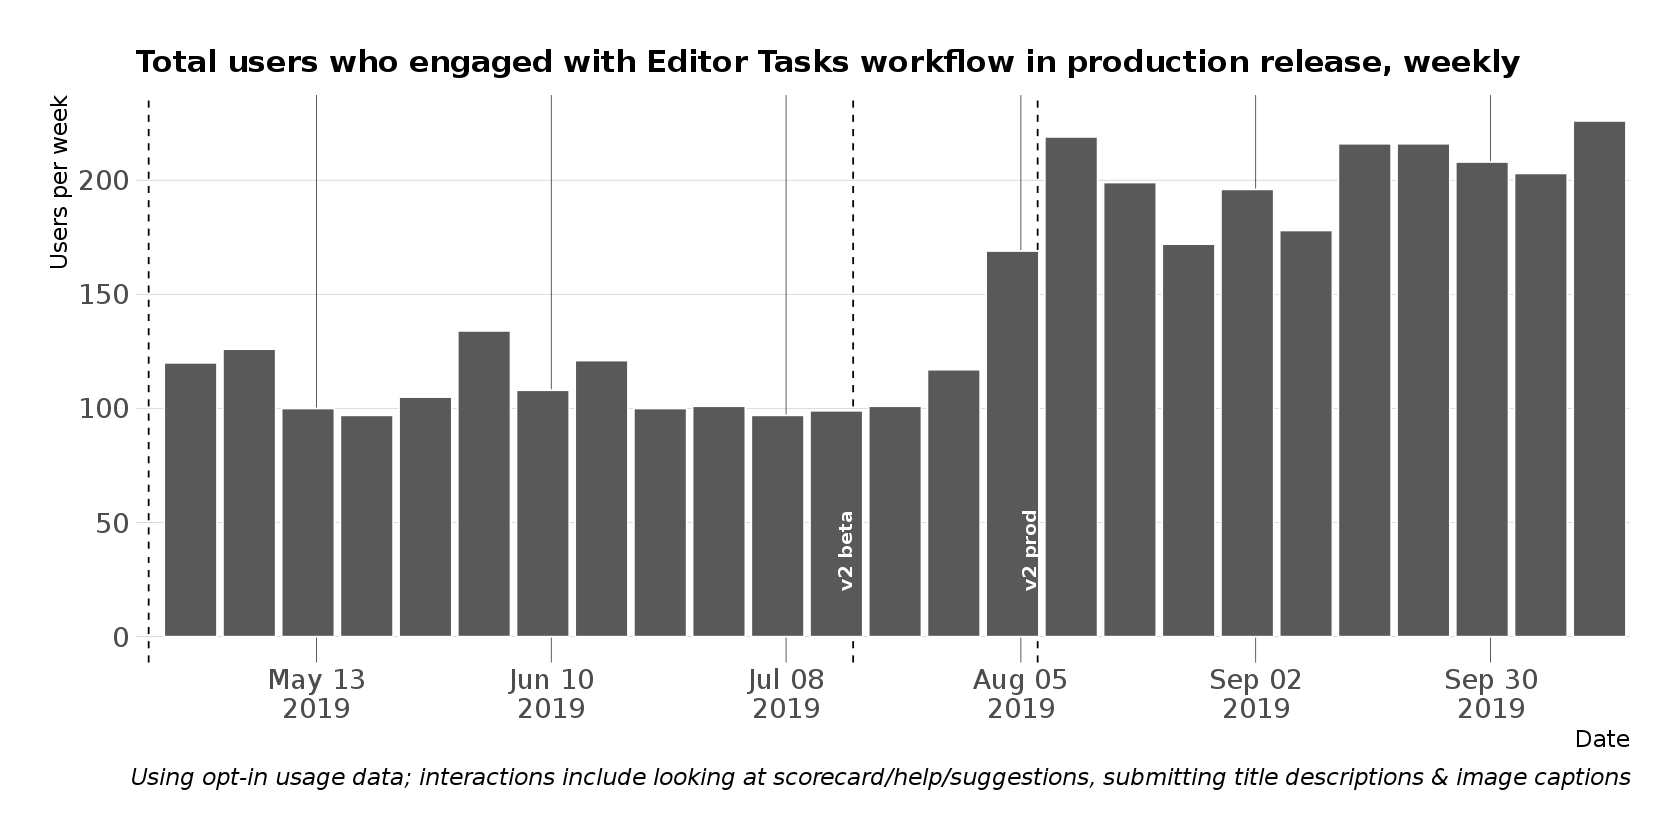

In [30]:
options(repr.plot.width = 14, repr.plot.height = 7)
daily_stats %>%
    # aggregate by week:
    mutate(date = lubridate::floor_date(date, "week")) %>%
    group_by(date) %>%
    summarize(total_users = sum(total_users), days = dplyr::n()) %>%
    ungroup %>%
    keep_where(days == 7) %>%
    ggplot() +
    geom_vline(aes(xintercept = date), linetype = "dashed", data = feature_release_dates) +
    geom_col(aes(x = date, y = total_users), position = "stack", color = "white") +
    geom_text(aes(x = date - 1, y = 20, label = release),
              size = 4, angle = 90, vjust = "middle", hjust = "left", fontface = "bold", color = "white",
              data = keep_where(feature_release_dates, release != "v1 beta")) +
    scale_y_continuous(labels = compress) +
    scale_x_date(date_breaks = "4 weeks", minor_breaks = NULL, date_labels = "%b %d\n%Y", expand = c(0, 0.5)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 14, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), panel.grid.major.x = element_line(color = "gray10")) +
    labs(
        title = "Total users who engaged with Editor Tasks workflow in production release, weekly",
        caption = "Using opt-in usage data; interactions include looking at scorecard/help/suggestions, submitting title descriptions & image captions",
        x = "Date", y = "Users per week", fill = "Users"
    )

### Help and Scorecard

While in the Editor Tasks workflow, users can look at a scorecard of their contributions or look up helpful information (which opens [mw:Wikimedia Apps/Suggested edits](https://www.mediawiki.org/wiki/Wikimedia_Apps/Suggested_edits) in their preferred web browser). In the last 30 days of usage, we can calculate the proportion of people who looked at either and how many of those users looked at help/scorecard multiple times in a single Editor Tasks sub-session.

In [31]:
events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    group_by(install_id) %>%
    summarize(help = sum(n_help) > 0, scorecard = sum(n_scorecard) > 0) %>%
    ungroup %>%
    gather(looked_at, yes, -install_id) %>%
    group_by(looked_at) %>%
    summarize(n_yes = sum(yes), n_total = n()) %>%
    ungroup %>%
    mutate(prop = n_yes / n_total) %>%
    dplyr::transmute(
        looked_at = paste("Users who, during any session, looked at", looked_at),
        stat = sprintf("%.1f%% (%.0f/%.0f)", 100 * prop, n_yes, n_total)
    ) %>%
    spread(looked_at, stat) %>%
    to_html(align = "c")

"Users who, during any session, looked at help","Users who, during any session, looked at scorecard"
21.1% (113/536),43.8% (235/536)


Proportion of users who looked at help multiple times in any one of their sub-sessions, out of users who looked at help at least once in all of their interactions with the Editor Tasks workflow:

In [32]:
events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    group_by(install_id) %>%
    summarize(
        help = any(n_help > 0),
        help_multi = any(n_help > 1)
    ) %>%
    ungroup %>%
    keep_where(help) %>%
    summarize(n_yes = sum(help_multi), n_total = n()) %>%
    ungroup %>%
    mutate(prop = n_yes / n_total) %>%
    dplyr::transmute(Users = sprintf("%.1f%% (%.0f/%.0f)", 100 * prop, n_yes, n_total)) %>%
    to_html(align = "c")

Users
28.3% (32/113)


Proportion of users who looked at their scorecard multiple times in any one of their sub-sessions, out of users who looked at their scorecard at least once in all of their interactions with the Editor Tasks workflow:

In [33]:
events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    group_by(install_id) %>%
    summarize(
        scorecard = any(n_scorecard > 0),
        scorecard_multi = any(n_scorecard > 1)
    ) %>%
    ungroup %>%
    keep_where(scorecard) %>%
    summarize(n_yes = sum(scorecard_multi), n_total = n()) %>%
    ungroup %>%
    mutate(prop = n_yes / n_total) %>%
    dplyr::transmute(Users = sprintf("%.1f%% (%.0f/%.0f)", 100 * prop, n_yes, n_total)) %>%
    to_html(align = "c")

Users
35.3% (83/235)


### Time spent

The in-app analytics also enable us to look at how much time users spend in the Editor Tasks workflow. While browsing suggestions of articles to add descriptions to, users may also open the article to read it, which pauses the timer. If the user taps the system Back button, they go back to the Editor Tasks workflow and the timer resumes, but if they exit to the feed from article view, that terminates their Editor Tasks session and a session summary is sent to us.

The user may go into the Editor Tasks screen multiple times during their overall session, so when we refer to "total time spent" we are referring to the sum of the time spent across those "sub-sessions" within the overall session. When we refer to "total time spent per day", we are referring to how much time a user spent in the Editor Tasks workflow across all their sessions in a given day.

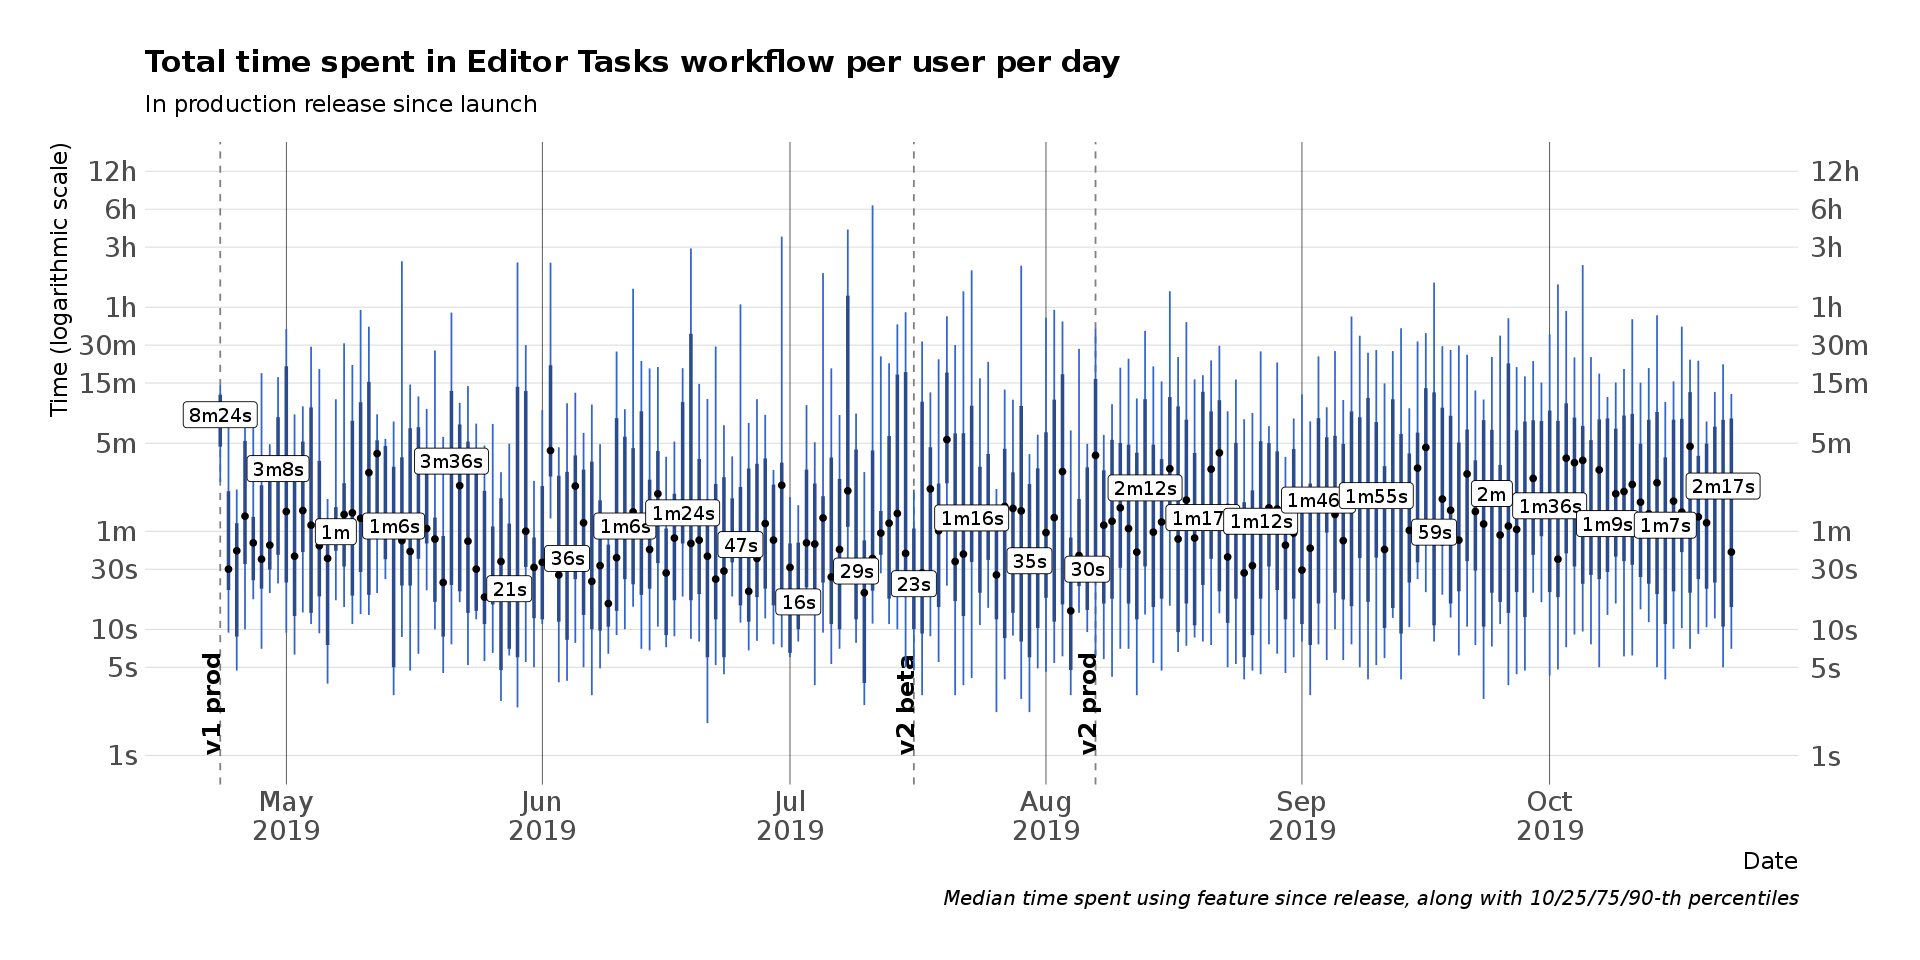

In [34]:
options(repr.plot.width = 16, repr.plot.height = 8)
ggplot(daily_stats) +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_text(aes(x = date, y = 1, label = release), data = feature_release_dates, size = 5, angle = 90,
              vjust = "bottom", hjust = "left", fontface = "bold") +
    geom_segment(aes(x = date, xend = date, y = time_spent_10, yend = time_spent_90),
                 size = 0.5, color = "#3366cc") +
    geom_segment(aes(x = date, xend = date, y = time_spent_25, yend = time_spent_75),
                 size = 1, color = "#2a4b8d") +
    geom_point(aes(x = date, y = time_spent_middle)) +
    geom_label(
        aes(x = date, y = time_spent_middle,
            label = gsub("m (0s)?", "m", tolower(lubridate::seconds_to_period(round(time_spent_middle))))),
        size = 4, data = keep_where(daily_stats, day %% 7 == 1)
    ) +
    scale_x_date(minor_breaks = NULL, date_breaks = "1 month", date_labels = "%b\n%Y") +
    scale_y_log10(
        label = function(x) {
            y <- tolower(lubridate::seconds_to_period(round(x)))
            z <- gsub(" 0[hms]", "", y)
            return(z)
        },
        breaks = c(1, 5, 10, 30, 60, 60 * 5, 60 * 15, 60 * 60 * c(0.5, 1, 3, 6, 12)),
        sec.axis = sec_axis(~ ., label = derive(), breaks = derive())          
    ) +
    coord_cartesian(ylim = c(1, 60 * 60 * 12), xlim = usage_date_range$title_descriptions) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_line(color = "gray10")) +
    labs(
        title = "Total time spent in Editor Tasks workflow per user per day",
        x = "Date", y = "Time (logarithmic scale)",
        subtitle = "In production release since launch",
        caption = "Median time spent using feature since release, along with 10/25/75/90-th percentiles"
    )

### Interaction with suggestions

In the Editor Tasks workflow, the user can look at many suggestions before seeing one that they would like to add a description for (or translate a description for, as the case may be). In the same sub-session, they may even go back to a previously seen suggestion and decide that they want to add/translate a description after all. They may also tap ("click") on a suggestion, change their mind, then change their mind again, and tap on it once more. We track both kinds of clicks: *unique* clicks (maximum 1 click per suggested article) and *total* clicks.

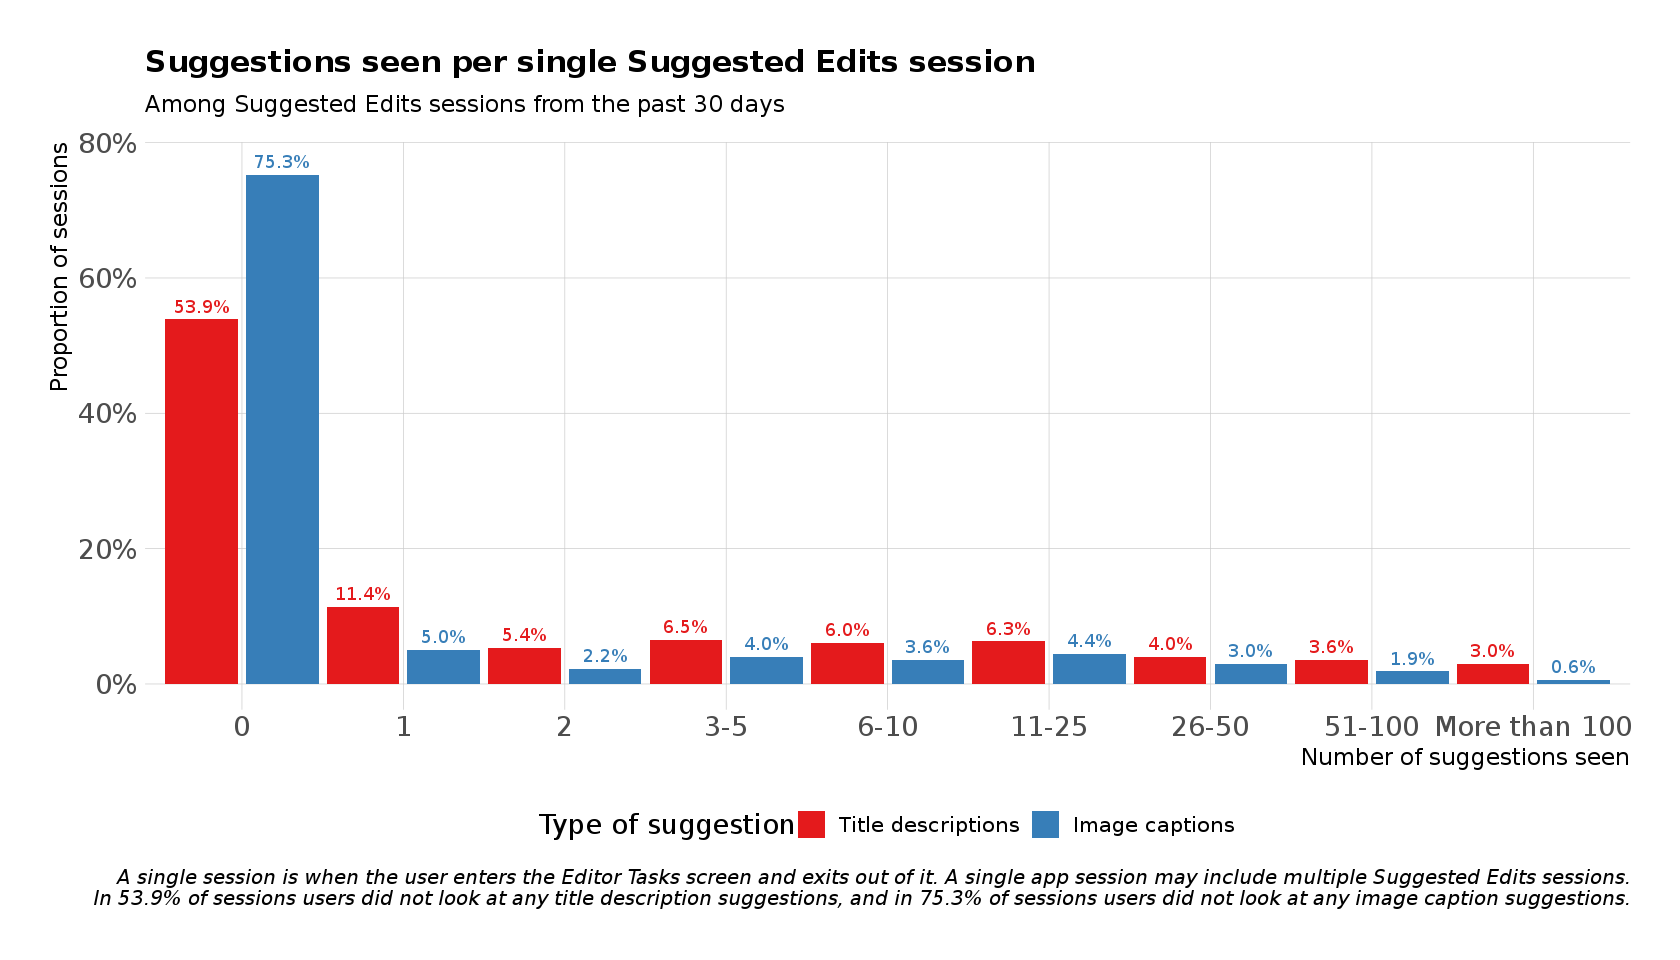

In [35]:
options(repr.plot.width = 14, repr.plot.height = 8)

suggestions_seen_per_subsession <- events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    mutate(
        `Title descriptions` = cut(n_td_suggestions, c(-Inf, 0, 1, 2, 5, 10, 25, 50, 100, Inf)),
        `Image captions` = cut(n_ic_suggestions, c(-Inf, 0, 1, 2, 5, 10, 25, 50, 100, Inf))
    )

levels(suggestions_seen_per_subsession$`Title descriptions`) <- c(
  "0", "1", "2", "3-5", "6-10", "11-25", "26-50", "51-100", "More than 100"
)
levels(suggestions_seen_per_subsession$`Image captions`) <- c(
  "0", "1", "2", "3-5", "6-10", "11-25", "26-50", "51-100", "More than 100"
)

suggestions_seen_per_subsession <- suggestions_seen_per_subsession %>%
    select(`Title descriptions`, `Image captions`) %>%
    gather(edit_type, seen) %>%
    dplyr::count(edit_type, seen) %>%
    ungroup %>%
    mutate(
        edit_type = factor(edit_type, c("Title descriptions", "Image captions")),
        seen = factor(seen, c("0", "1", "2", "3-5", "6-10", "11-25", "26-50", "51-100", "More than 100"))
    ) %>%
    group_by(edit_type) %>%
    mutate(prop = n / sum(n)) %>%
    ungroup

zero_suggestions_seen <- suggestions_seen_per_subsession %>%
    keep_where(seen == "0") %>%
    mutate(percent = scales::percent(prop, 0.1)) %>%
    select(edit_type, percent) %>%
    spread(edit_type, percent)
explainer <- paste(
    "A single session is when the user enters the Editor Tasks screen and exits out of it. A single app session may include multiple Suggested Edits sessions.\n",
    "In", zero_suggestions_seen$`Title descriptions`, "of sessions users did not look at any title description suggestions, and",
    "in", zero_suggestions_seen$`Image captions`, "of sessions users did not look at any image caption suggestions."
)

ggplot(suggestions_seen_per_subsession, aes(x = seen, y = prop)) +
    geom_col(aes(fill = edit_type), position = position_dodge(width = 1)) +
    geom_text(aes(label = sprintf("%.1f%%", 100 * prop), color = edit_type, y = prop + 0.01),
              position = position_dodge(width = 1), vjust = "bottom", show.legend = FALSE) +
    scale_y_continuous(labels = scales::percent_format(1)) +
    scale_color_brewer(palette = "Set1") +
    scale_fill_brewer(palette = "Set1") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14, strip_text_size = 22) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank()) +
    labs(
        x = "Number of suggestions seen", y = "Proportion of sessions", fill = "Type of suggestion",
        title = "Suggestions seen per single Suggested Edits session",
        subtitle = "Among Suggested Edits sessions from the past 30 days",
        caption = explainer
    )

The following shows the daily breakdowns of three engagement metrics:

- "**Suggestion clickthrough rate**": % of suggestions clicked on (unique clicks / impressions)
- "**Edit per clicked suggestion rate**": % of time the user clicked on a suggestion and then made the edit (edits / unique clicks)
<!-- - "**Edit per suggestion rate**": % of suggestions which resulted in an edit -->

In [36]:
tidy_rates <- daily_stats %>%
    select(date, day, dplyr::contains("rate")) %>%
    gather("metric", "value", -c(date, day)) %>%
    keep_where(!is.na(value)) %>%
    mutate(
        edit_type = dplyr::case_when(
            grepl("^description", metric) ~ "Title descriptions",
            grepl("^caption", metric) ~ "Image captions",
            TRUE ~ "Overall"
        ),
        key = sub(".*_rate_([a-z]+)$", "\\1", metric),
        metric = sub("^((description|caption)_)?([a-z]+)_rate.*", "\\3", metric),
        metric = factor(metric, c("clickthrough", "success"), c("Suggestion clickthrough rate", "Edit per clicked suggestion rate"))
    ) %>%
    spread(key, value, fill = 0)

In [37]:
rate_colors <- c(
    "Edit per clicked suggestion rate" = "#dd3333",
    "Edit per suggestion rate" = "#ac6600",
    "Suggestion clickthrough rate" = "#00af89"
)
daily_usage_plot <- function(rate_data, plot_title) {
    ggplot(rate_data) +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_text(aes(x = date, y = 0, label = release), data = feature_release_dates, size = 5, angle = 90,
              vjust = "bottom", hjust = "left", fontface = "bold") +
    geom_segment(aes(x = date, xend = date, y = lower, yend = upper, color = metric), size = 1.1) +
    geom_point(aes(x = date, y = middle, color = metric), size = 4, show.legend = FALSE) +
    geom_point(aes(x = date, y = middle), size = 2, color = "white") +
    scale_color_manual(values = rate_colors) +
    scale_fill_manual(values = rate_colors) +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1),
                       expand = c(0, 0.1), breaks = seq(0, 1, 0.1), minor_breaks = NULL,
                       sec.axis = sec_axis(~ ., labels = derive(), breaks = derive())) +
    scale_x_date(expand = c(0, 2), date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    facet_wrap(~ metric, ncol = 1) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14, strip_text_size = 16) +
    theme(legend.position = "bottom", panel.grid.major.x = element_line(color = "gray10"),
          panel.grid.major.y = element_line(color = "gray80")) +
    labs(
        title = plot_title,
        subtitle = "Averages with 80% confidence intervals of Suggested Edits usage in production release",
        x = "Date", y = NULL, color = "Metric"
    )
}

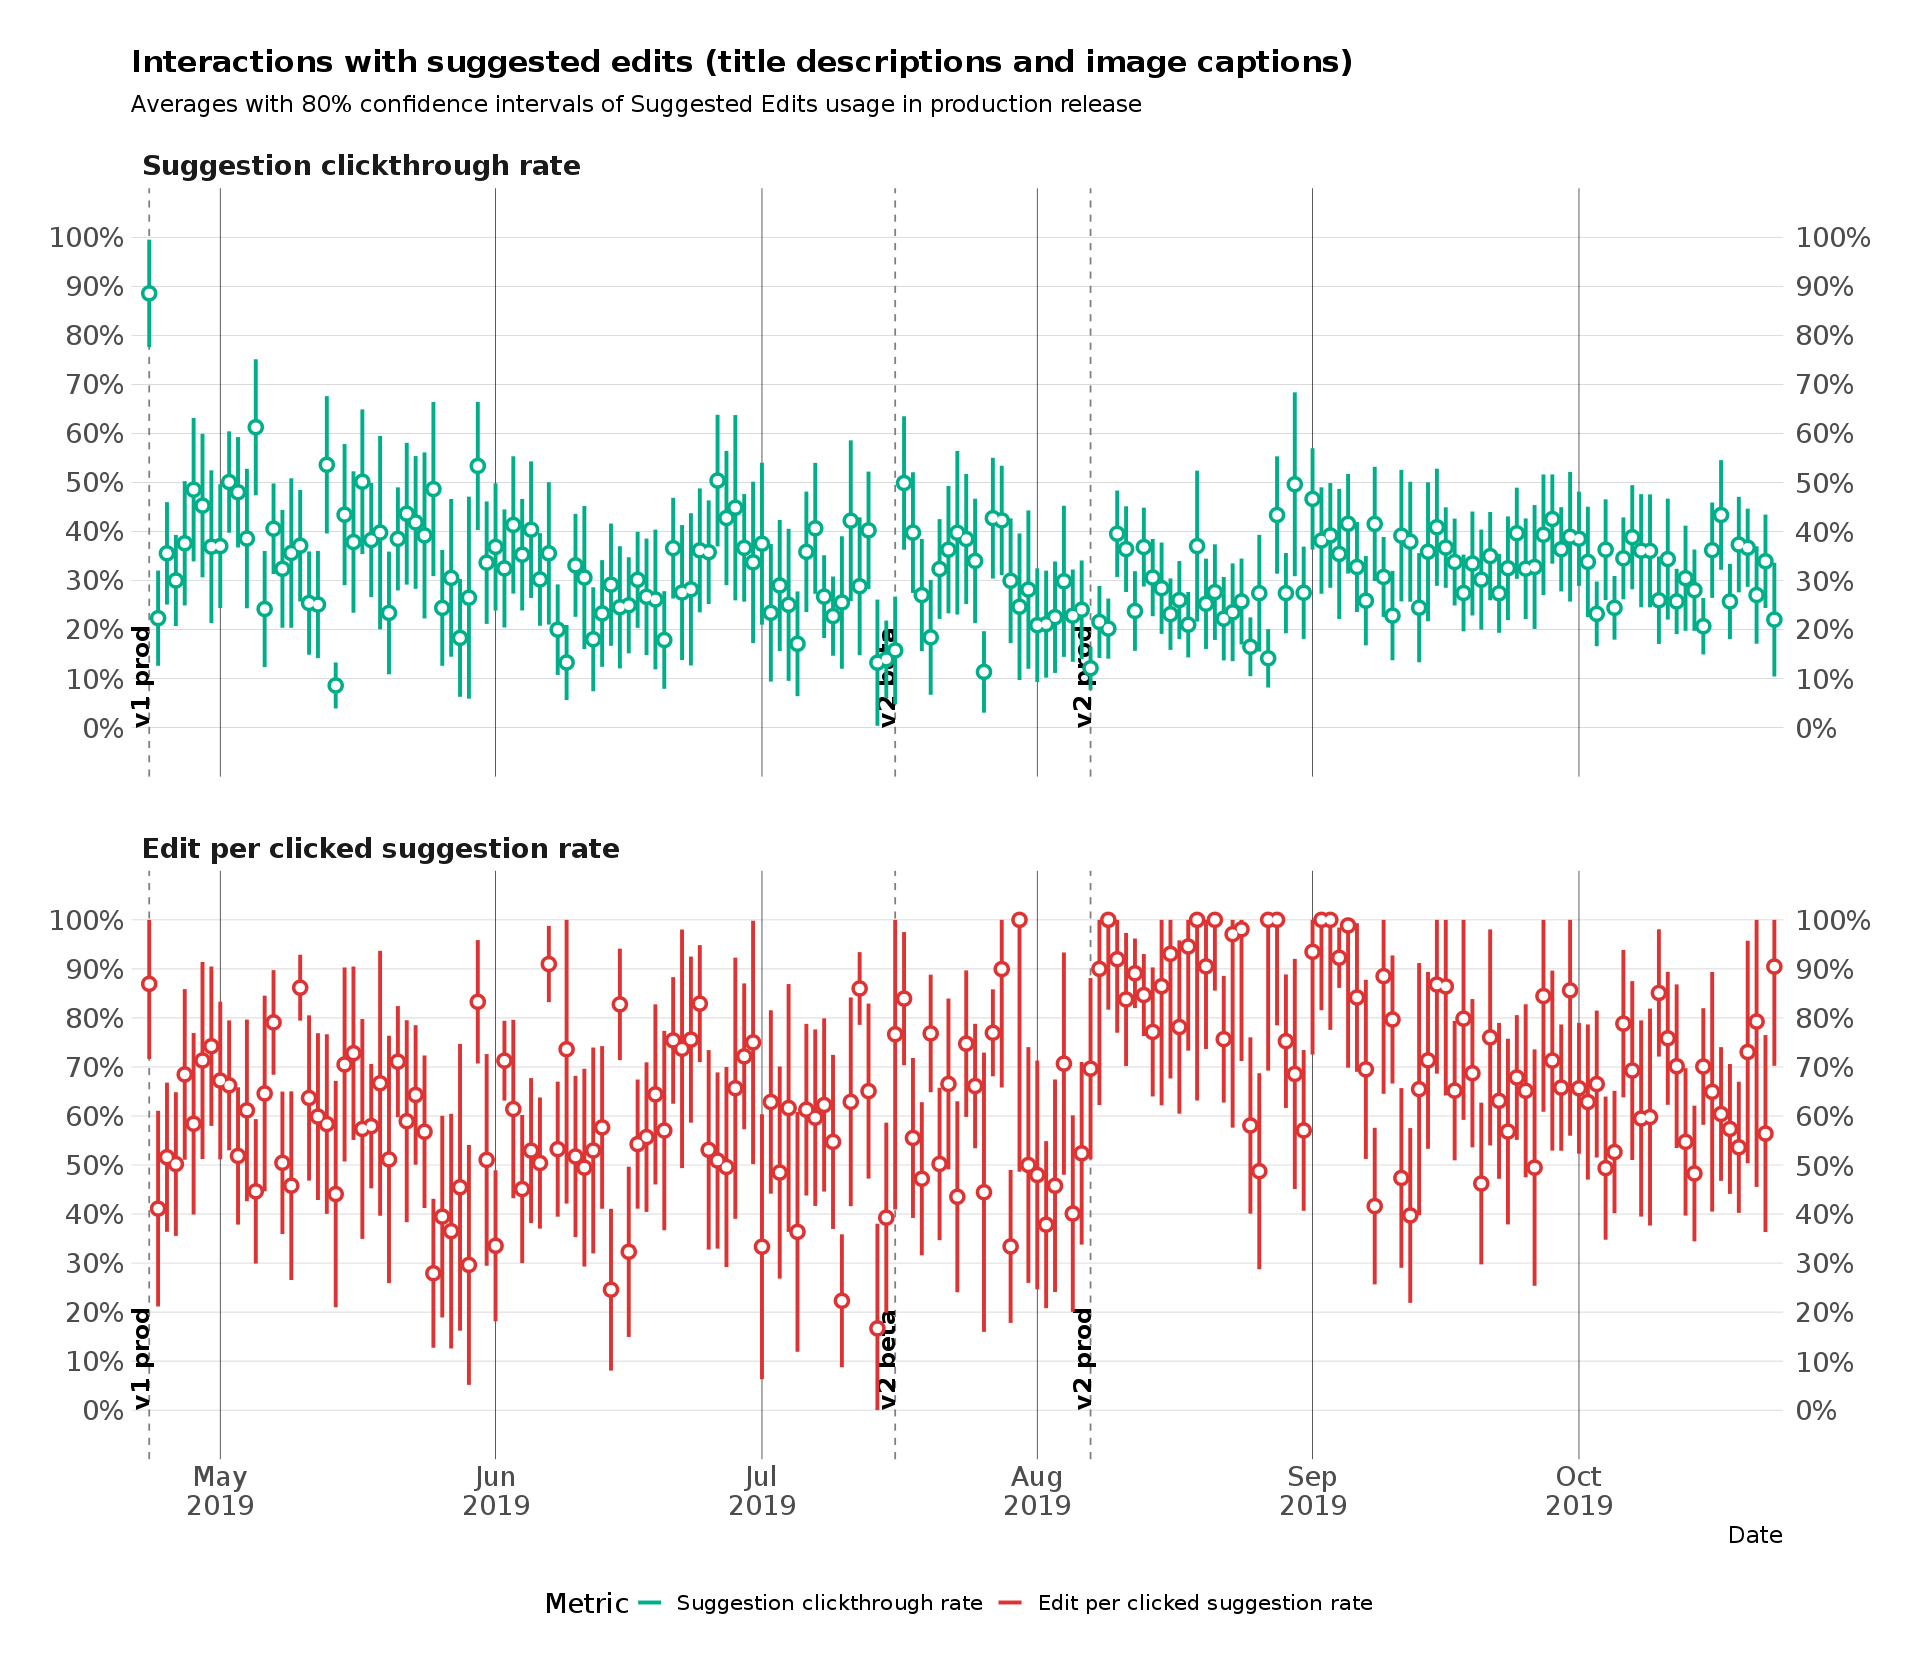

In [48]:
options(repr.plot.width = 16, repr.plot.height = 14)
tidy_rates %>%
    keep_where(edit_type == "Overall") %>%
    daily_usage_plot("Interactions with suggested edits (title descriptions and image captions)") +
    coord_cartesian(xlim = usage_date_range$title_descriptions)

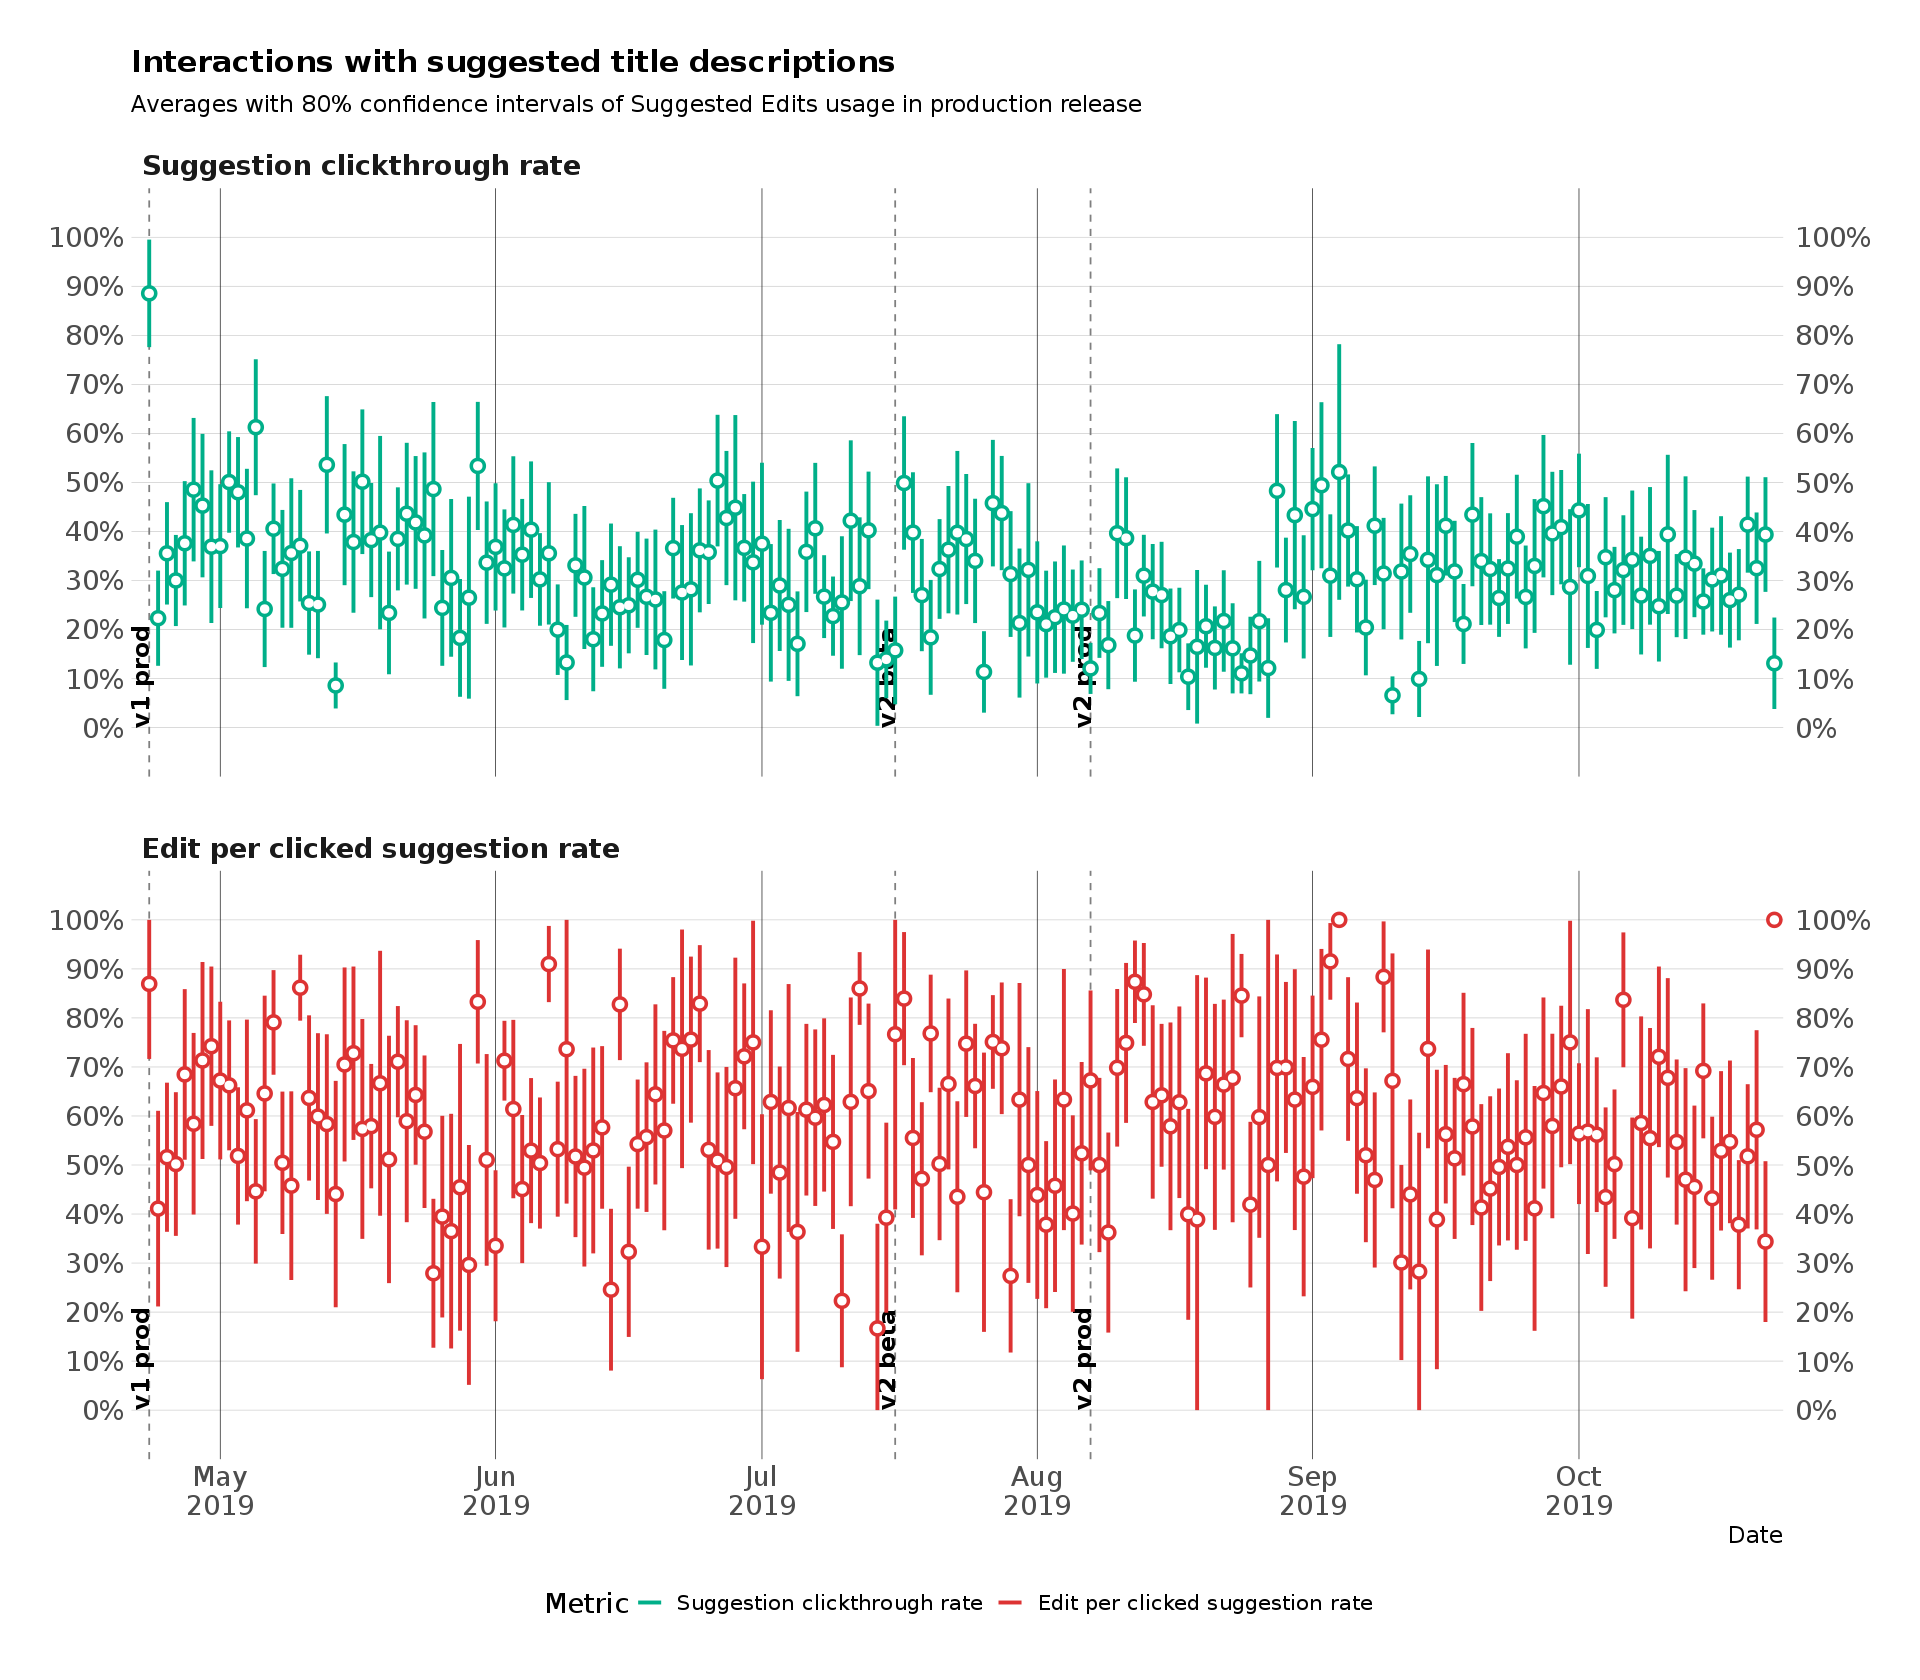

In [49]:
tidy_rates %>%
    keep_where(edit_type == "Title descriptions") %>%
    daily_usage_plot("Interactions with suggested title descriptions") +
    coord_cartesian(xlim = usage_date_range$title_description)

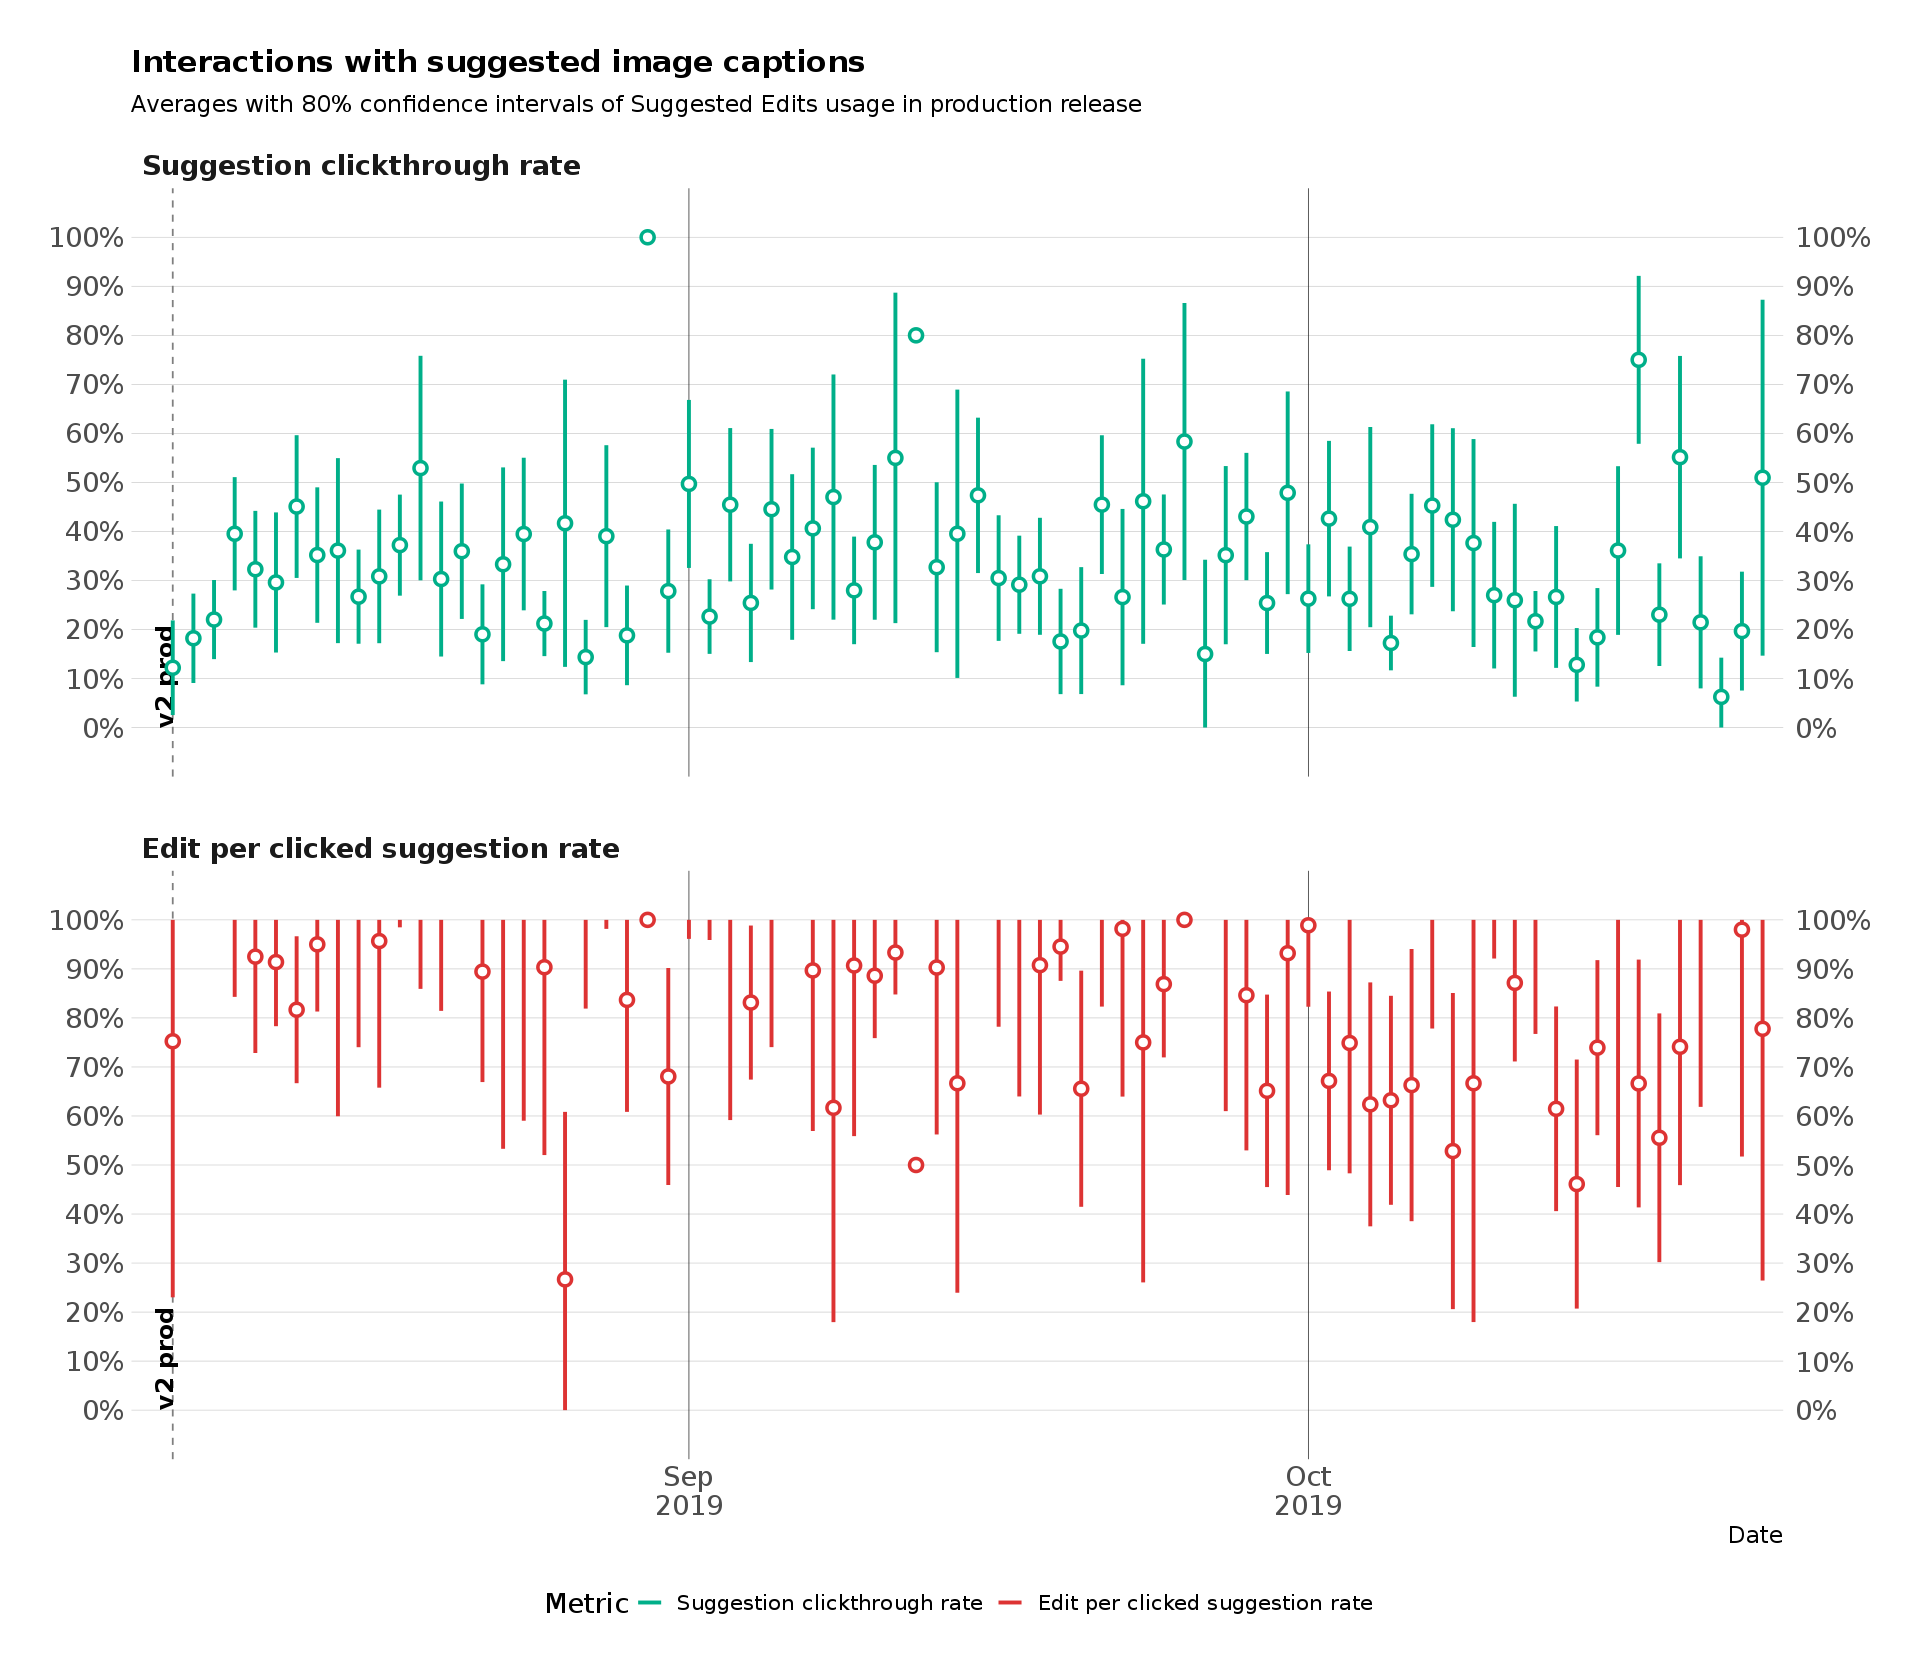

In [50]:
if ("Image captions" %in% tidy_rates$edit_type && "v2 prod" %in% feature_release_dates$release) {
    suppressMessages({
        image_captions_interactions_plot <- tidy_rates %>%
            keep_where(edit_type == "Image captions") %>%
            daily_usage_plot("Interactions with suggested image captions") +
            coord_cartesian(xlim = usage_date_range$image_caption)
        
    })
    suppressWarnings(print(image_captions_interactions_plot))
}

## Retention stats

By looking at Wikidata edit data (rather than usage data from opted-in users), we can find out how many editors use the Suggested Edits feature to make contributions just once or multiple times:

In [41]:
editor_data %>%
    keep_where(suggested_edits > 0) %>%
    group_by(user_name) %>%
    summarize(returned = n() > 1) %>%
    dplyr::count(returned) %>%
    mutate(returned = factor(
        returned,
        c(FALSE, TRUE),
        c("for only one day", "on multiple days")
    )) %>%
    mutate(prop = sprintf("%.1f%%", 100 * n / sum(n))) %>%
    rename(
        `Made contributions with Suggested Edits (SE)` = returned,
        `Android app editors` = n,
        `Proportion (out of total who have contributed with SE at least once)` = prop
    ) %>%
    to_html(align = "r")

Made contributions with Suggested Edits (SE),Android app editors,Proportion (out of total who have contributed with SE at least once)
for only one day,3971,76.5%
on multiple days,1222,23.5%


In [42]:
consecutive_streaks <- editor_data %>%
    keep_where(suggested_edits > 0) %>%
    arrange(user_name, date) %>%
    group_by(user_name) %>%
    mutate(
        differences = na2zero(c(NA, diff(date))),
        sequence = cumsum(differences != 1)
    ) %>%
    group_by(user_name, sequence) %>%
    summarize(
        started = min(date),
        days_lasted = n(),
        total_edits = sum(suggested_edits)
    ) %>%
    ungroup

Longest consecutive streaks of making contributions through Suggested Edits:

In [43]:
consecutive_streaks %>%
    dplyr::top_n(3, days_lasted) %>%
    arrange(dplyr::desc(days_lasted), dplyr::desc(total_edits)) %>%
    head(10) %>%
    mutate(user = sprintf("(%.0f)", 1:n())) %>%
    select(user, started, days_lasted, total_edits) %>%
    rename(
        User = user,
        `Streak started` = started,
        `Days lasted` = days_lasted,
        `Total edits made through SE` = total_edits
    ) %>%
    to_html(align = "r")

User,Streak started,Days lasted,Total edits made through SE
(1),2019-05-16,40,1276
(2),2019-09-21,32,1287
(3),2019-09-05,17,105


When looking at the last 30 days of *usage*<sup>†</sup> data (so as to not deflate the rate two months later with re-installs and users who uninstalled the app or switched devices), we get the following retention rates:

- "**Next-day retention***": % of users who went into the Editor Tasks screen again the next day
- "**Week retention**": % of users who went into the Editor Tasks screen again within 7 days (not necessarily after initial usage)
- "**Month retention**": % of users who went into the Editor Tasks screen again within 30 days (not necessarily after initial usage)

That is, this is looking at engagement with the feature -- including just looking at suggestions or the scorecard; not necessarily actually making contributions through it.

<sup>†</sup>: from app users who are opted in to sharing usage data with us

In [44]:
retention_rates <- per_user_stats %>%
    select(install_id, date, returned) %>%
    keep_where(date >= (max(per_user_stats$date) - 30)) %>%
    # For debugging:
    # rbind(
    #     dplyr::tibble(
    #         release = c("Beta release", "Production release"),
    #         install_id = c("01ffb902-ec29-4e90-9c7c-5e30400a6ab8", "01b8c744-c6c3-422c-859d-2820d677429e"),
    #         date = as.Date(c("2019-04-06", "2019-04-27")),
    #         returned = TRUE
    #     )
    # ) %>%
    arrange(install_id, date) %>%
    group_by(install_id) %>%
    mutate(last_usage = dplyr::lag(date), days_since = date - last_usage) %>%
    summarize(
        `2` = any(days_since == 1), # user used the feature again the next day
        `7` = any(days_since <= 7), # user used the feature multiple times per week
        `30` = any(days_since <= 30) # user used the feature multiple times per month
    ) %>%
    ungroup %>%
    gather(days, retained, -install_id) %>%
    mutate(retained = ifelse(is.na(retained), FALSE, retained)) %>%
    group_by(days) %>%
    summarize(retention_rate = mean(retained), retained = sum(retained), n_users = n()) %>%
    ungroup %>%
    mutate(days = factor(days, c(2, 7, 30), c("Next-day retention", "Week retention", "Month retention")))

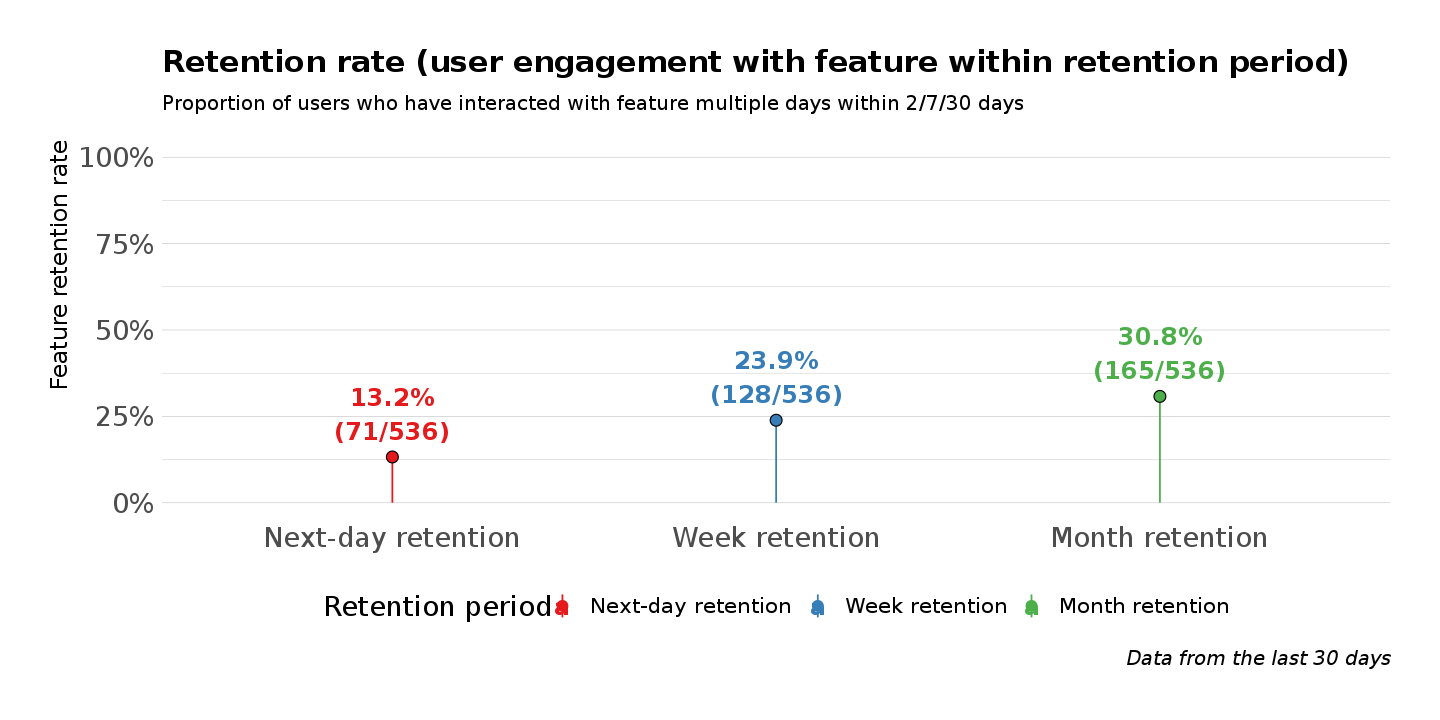

In [45]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(retention_rates, aes(x = factor(days), color = factor(days))) +
    geom_pointrange(aes(ymin = 0, y = retention_rate, ymax = retention_rate), position = position_dodge(width = 0.8)) +
    geom_point(aes(y = retention_rate), position = position_dodge(width = 0.8), color = "black", shape = 1, size = 3) +
    geom_text(
        aes(y = retention_rate + 0.05, label = sprintf("%.1f%%\n(%.0f/%.0f)", 100 * retention_rate, retained, n_users)),
        position = position_dodge(width = 0.8), vjust = "bottom", size = 5, fontface = "bold"
    ) +
    scale_color_brewer(palette = "Set1") +
    scale_y_continuous(limits = c(0, 1), labels = scales::percent_format(1)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, caption_size = 12, axis_title_size = 14) +
    theme(legend.position = "bottom", panel.grid.major.x = element_blank()) +
    labs(
        x = NULL, y = "Feature retention rate", color = "Retention period",
        title = "Retention rate (user engagement with feature within retention period)",
        subtitle = "Proportion of users who have interacted with feature multiple days within 2/7/30 days",
        caption = "Data from the last 30 days"
    )

For more information or to bring up issues with this report, contact <a href="https://www.mediawiki.org/wiki/User:MPopov_(WMF)">Mikhail Popov</a>. For details on in-app analytics instrumentation, contact <a href="https://www.mediawiki.org/wiki/User:DBrant_(WMF)">Dmitry Brant</a>. For more information on Suggested Edits feature, contact <a href="https://www.mediawiki.org/wiki/User:CGauthier_(WMF)">Charlotte Gauthier</a>. All of the code and queries used for this report are in [this repository](https://github.com/bearloga/wmf-android-suggested-edits).

In [46]:
cat("Report generated on", format(lubridate::now(), "%Y-%m-%d at %H:%M:%S UTC"))

Report generated on 2019-10-23 at 18:14:06 UTC